# Projet EnergiSight - Phase 1 : EDA Deep-Dive
**Startup :** GreenSight Lomé  


Ce notebook contient l'Analyse Exploratoire des Données (EDA) pour le dataset de Seattle 2016. L'objectif est de préparer les données pour prédire la consommation d'énergie et les émissions de CO2 des bâtiments non-résidentiels.

In [ ]:
from folium.plugins.heat_map import HeatMap
#importation des bibliotheques
import numpy as np
import pandas as pd
import math
import datetime as datetime
import warnings

#statistique bibliotheque
from scipy import stats
from scipy.stats import shapiro, skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

#visulalisation bibliotheque
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import missingno as msno

#visualisation interactive bibliotheque
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as make_subplots
import geopandas as gpd

## Paramétrage de l'affichage

Pour assurer la cohérence visuelle et la lisibilité des analyses du projet EnergiSight, nous définissons des standards de présentation

In [ ]:
sns.set_theme(style='whitegrid',palette='viridis')
plt.rcParams['figure.figsize']=(12,8)
plt.rcParams['font.size']=12

#configuration pour pandas
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
# Constantes pour le projet GreenSight
TARGET_CO2 = 'totalghgemissions'
TARGET_ENERGY = 'siteenergyuse_kbtu'
SEED = 42 # Pour la reproductibilité des analyses futures

# Boîte à Outils EnergiSight

## Outils d'Audit et d'Intégrité
Méthodologie :
Conformément à notre approche de R&D , nous effectuons un audit de santé du jeu de données de Seattle. L'objectif est double :

Audit de Type et Complétude : Identifier les types de données inappropriés (ex: codes postaux traités comme nombres) et quantifier la profondeur des données manquantes pour orienter les futures stratégies d'imputation.

Vérification de la Cohérence Physique : S'assurer que les lois élémentaires de l'urbanisme et de la physique sont respectées (ex: la surface totale ne peut être inférieure à la surface du bâtiment seul) afin d'éliminer les erreurs de saisie qui pourraient biaiser l'apprentissage du modèle.

In [ ]:
def analyze_data_types(df):
  '''
  analyse approfondie des types avec aletes de coherence
  '''
  type_info=pd.DataFrame({
      'Colonne': df.columns,
      'Type':df.dtypes.values,
      'Valeurs_Uniques':df.nunique().values,
      'Valeurs_Manquantes':df.isnull().sum().values,
      'pourcentage_Null':(df.isnull().sum()/len(df) * 100).values,
      'Exemples':[df[col].dropna().unique()[:3] for col in df.columns]
  })
  if any(col for col in df.columns if 'zip' in col.lower() and df[col].dtype != 'object'):
    print('les colonnes code postal ne sont pas en string !')

  return type_info

In [ ]:
def check_physical_consistency(df):
  #verification si les lois naturel et physique sont respecter
  inconsistencies=[]
  #test surface
  mask_surf = df['propertygfatotal'] < df['propertygfabuildings']
  if mask_surf.any():
    inconsistencies.append({'type': 'surface','count': mask_surf.sum(), 'desc':'total<bati'})

  return pd.DataFrame(inconsistencies)

## Outils Statistiques & Outliers
Dans le cadre de l'étude de la consommation énergétique et des émissions de CO2​, nous utilisons une approche statistique robuste pour isoler les valeurs aberrantes :

* Z-Score Robuste (MAD) : Contrairement à l'écart-type classique, la Déviation Médiane Absolue (MAD) n'est pas influencée par les valeurs extrêmes elles-mêmes. Cela permet de détecter des anomalies sans biaiser le diagnostic par le "bruit" des données.

* Visualisation par Boxplot : Identification visuelle de la dispersion des données pour valider si un outlier est une erreur de saisie ou un bâtiment à haute intensité énergétique réelle.

In [ ]:
def detect_outliers_robust(df, column):
  # compare IQR et Z-score robuste (MAd) ppour identifier les points extremes
  data=df[column].dropna()
  median=data.median()
  mad=stats.median_abs_deviation(data, scale='normal')

  #seuil MAD à 3.5
  outliers_mad=data[np.abs(0.6745* (data-median)/mad)>3.5] if mad > 0 else []

  #visualisation
  fig, ax= plt.subplots(1,2,figsize=(15,4))
  sns.boxplot(x=data, ax=ax[0], color='skyblue').set_title(f'boxplot {column}')
  plt.show()

  return{'count_mad': len(outliers_mad), 'pct_mad': (len(outliers_mad)/len(data))*100}

## Analyse de la Cible et des Corrélations
Pour garantir la performance des modèles prédictifs de GreenSight, nous analysons ici la structure statistique de nos variables dépendantes et indépendantes :

* Normalisation des Cibles : Les données d'émissions de CO2​ et de consommation présentent souvent une forte asymétrie (skewness). Nous testons la transformation logarithmique (log(1+x)) pour linéariser les relations et stabiliser la variance des futurs modèles.

* Diagnostic de Multicolinéarité (VIF) : Le Variance Inflation Factor nous permet de détecter les variables qui apportent une information redondante. C'est une étape cruciale pour simplifier le modèle et assurer l'interprétabilité des coefficients.

* Analyse Univariée 360° : Une inspection systématique des variables numériques et catégorielles pour identifier les tendances dominantes et les besoins en nettoyage (valeurs manquantes).

In [ ]:
def analyse_target_distrubution(df, target_col):
  #analyse de la normalité
  data=df[target_col].dropna()
  data_log=np.log1p(data)

  fig, ax =plt.subplots(1,2, figsize=(16,5))
  sns.histplot(data=data,kde=True,ax=ax[0]).set_title(f'Original (Skew: {skew(data):.2f})')
  sns.histplot(data=data_log,kde=True,ax=ax[1]).set_title(f'Log-Transform (Skew: {skew(data_log):.2f})')
  plt.show()


In [ ]:
def calculate_vif(df, threshold=10):
    """Identifie la multicolinéarité pour stabiliser les futurs modèles."""
    numeric_df = df.select_dtypes(include=[np.number]).dropna()
    vif_data = pd.DataFrame()
    vif_data["Variable"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

In [ ]:
def univariate_analysis(df, column, categorical=False, top_n=10):
    """
    Analyse complète d'une variable : statistiques, manquants et visualisation.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import skew, kurtosis

    # 1. Vérification de l'existence de la colonne
    if column not in df.columns:
        print(f"La colonne '{column}' n'existe pas dans le dataset.")
        return None

    data = df[column].dropna()

    # 2. Rapport de base
    report = {
        'column': column,
        'type': 'Categorical' if categorical else 'Numerical',
        'missing_values': df[column].isnull().sum(),
        'missing_percentage': (df[column].isnull().sum() / len(df)) * 100
    }

    # 3. Visualisation
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))

    if categorical:
        # --- Analyse Catégorielle ---
        order = df[column].value_counts().iloc[:top_n].index
        sns.countplot(data=df, y=column, order=order, ax=ax[0], palette="viridis")
        ax[0].set_title(f"Top {top_n} des catégories : {column}")

        # Pie chart pour la répartition
        counts = df[column].value_counts().iloc[:top_n]
        ax[1].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
        ax[1].set_title(f"Répartition de {column}")

    else:
        # --- Analyse Numérique ---
        report['mean'] = data.mean()
        report['median'] = data.median()
        report['std'] = data.std()
        report['skewness'] = skew(data)

        # Histogramme + KDE
        sns.histplot(data, kde=True, ax=ax[0], color="steelblue")
        ax[0].axvline(report['mean'], color='red', linestyle='--', label=f"Moyenne: {report['mean']:.2f}")
        ax[0].axvline(report['median'], color='green', linestyle='-', label=f"Médiane: {report['median']:.2f}")
        ax[0].set_title(f"Distribution de {column}")
        ax[0].legend()

        # Boxplot pour les outliers
        sns.boxplot(x=data, ax=ax[1], color="lightgreen")
        ax[1].set_title(f"Boxplot (Outliers) de {column}")

    plt.tight_layout()
    plt.show()

    return report

## Feature Engineering & Géospatial
Cette étape vise à enrichir le jeu de données par la création de variables métier et à préparer le terrain pour une modélisation sans biais :

* Enrichissement métier (Feature Engineering) : Création de variables comme l'âge du bâtiment (obsolescence thermique) et l'intensité énergétique au m2. Ces ratios permettent de comparer des bâtiments de tailles différentes sur une base équitable.

* Intelligence Géospatiale : Utilisation de cartes de chaleur interactives (Folium) pour identifier des clusters de haute consommation à Seattle. Cela permet de valider visuellement si la localisation (quartiers industriels vs résidentiels) est un prédicteur clé.

* Analyse de Redondance : Double vérification des corrélations (Pearson pour le linéaire, Spearman pour les rangs) afin de ne pas saturer le modèle avec des variables redondantes.

* Prévention du "Data Leakage" : Nettoyage rigoureux des colonnes qui contiennent déjà la réponse (ex: ghgemissionsintensity) pour garantir que le modèle apprend réellement à prédire et non à "tricher" avec des variables calculées a posteriori.

In [ ]:
def create_features(df):
  # genere  des ratio metier et autre
  df_e=df.copy()

  if 'yearbuilt' in df_e.columns:
    df_e['building_age']=2016-df_e['yearbuilt']

  if 'siteenergyuse_kbtu' in df_e.columns and 'propertygfatotal' in df_e.columns:
    df_e['energy_intensity']=df_e['siteenergyuse_kbtu']/df_e['propertygfatotal']

  return df_e

In [ ]:
def correlation_analysis(df, target_col=None, method='both', threshold=0.7):
    """
    Analyse les corrélations de Pearson (linéaire) et Spearman (rangs).
    Identifie les variables redondantes au-dessus du seuil (threshold).
    """
    results = {}

    # Sélection des colonnes numériques uniquement
    df_num = df.select_dtypes(include=[np.number])

    # 1. Calcul des matrices
    if method in ['pearson', 'both']:
        corr_p = df_num.corr(method='pearson')
        results['pearson'] = corr_p
        # Identification des paires fortement corrélées
        strong_p = corr_p.abs().unstack().sort_values(ascending=False)
        results['strong_pearson'] = strong_p[(strong_p > threshold) & (strong_p < 1.0)].drop_duplicates()

    if method in ['spearman', 'both']:
        corr_s = df_num.corr(method='spearman')
        results['spearman'] = corr_s
        # Identification des paires fortement corrélées
        strong_s = corr_s.abs().unstack().sort_values(ascending=False)
        results['strong_spearman'] = strong_s[(strong_s > threshold) & (strong_s < 1.0)].drop_duplicates()

    # 2. Visualisation si une cible est spécifiée
    if target_col and target_col in df_num.columns:
        plt.figure(figsize=(10, 6))
        target_corr = corr_p[target_col].sort_values(ascending=False)
        sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
        plt.title(f"Corrélation des variables avec la cible : {target_col}")
        plt.show()

    return results

In [ ]:
def geospatial_analysis(df, value_col='siteenergyuse_kbtu'):
    """Génère une carte de chaleur interactive de Seattle."""
    m = folium.Map(location=[47.6062, -122.3321], zoom_start=11, tiles='Stamen Toner', attr='Stamen Toner')
    heat_data = [[row['latitude'], row['longitude'], row[value_col]] for index, row in df.dropna(subset=['latitude', 'longitude', value_col]).iterrows()]
    HeatMap(heat_data, radius=15).add_to(m)
    return m

In [ ]:
def prepare_for_modeling(df, target_col):
    """Nettoie le Leakage, impute les NaNs et prépare l'encodage."""
    # Suppression automatique du Leakage connu de Seattle
    leakage_cols = ['osebuildingid', 'totalghgemissions', 'ghgemissionsintensity', 'siteeui_kbtu_sf']
    df_m = df.drop(columns=[c for c in leakage_cols if c in df.columns and c != target_col])

    # Imputation simple pour l'EDA
    for col in df_m.select_dtypes(include=[np.number]).columns:
        df_m[col] = df_m[col].fillna(df_m[col].median())

    return df_m

## Chargement et première inspection des données
Nous importons les données brutes de Seattle 2016. Immédiatement, nous procédons à une normalisation syntaxique des colonnes :

  * Snake_case : Conversion de tous les noms en minuscules.

  * Nettoyage des caractères spéciaux : Remplacement des espaces et parenthèses par des underscores.
  * Cette étape technique garantit une manipulation fluide des variables dans le code (autocomplétion et accès par attribut) et prévient les bugs lors des phases de modélisation.

In [ ]:
df_raw=pd.read_csv('/content/drive/MyDrive/D-CLIC/projet_energisight/data/2016_Building_Energy_Benchmarking.csv')
# normalisation des ccolonnes
df_raw.columns = [c.lower().replace(' ', '_').replace('/', '_').replace('(', '').replace(')', '') for c in df_raw.columns]
print(f"Dataset chargé : {df_raw.shape[0]} lignes × {df_raw.shape[1]} colonnes")

Dataset chargé : 3376 lignes × 46 colonnes


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   osebuildingid                    3376 non-null   int64  
 1   datayear                         3376 non-null   int64  
 2   buildingtype                     3376 non-null   object 
 3   primarypropertytype              3376 non-null   object 
 4   propertyname                     3376 non-null   object 
 5   address                          3376 non-null   object 
 6   city                             3376 non-null   object 
 7   state                            3376 non-null   object 
 8   zipcode                          3360 non-null   float64
 9   taxparcelidentificationnumber    3376 non-null   object 
 10  councildistrictcode              3376 non-null   int64  
 11  neighborhood                     3376 non-null   object 
 12  latitude            

In [ ]:
df_raw.describe(include='all')

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,city,state,zipcode,taxparcelidentificationnumber,councildistrictcode,neighborhood,latitude,longitude,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuildings,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,yearsenergystarcertified,energystarscore,siteeuikbtu_sf,siteeuiwnkbtu_sf,sourceeuikbtu_sf,sourceeuiwnkbtu_sf,siteenergyusekbtu,siteenergyusewnkbtu,steamusekbtu,electricitykwh,electricitykbtu,naturalgastherms,naturalgaskbtu,defaultdata,comments,compliancestatus,outlier,totalghgemissions,ghgemissionsintensity
count,3376.000,3376.000,3376,3376,3376,3376,3376,3376,3360.000,3376,3376.000,3376,3376.000,3376.000,3376.000,3368.000,3376.000,3376.000,3376.000,3376.000,3367,3356,3356.000,1679,1679.000,596,596.000,119,2533.000,3369.000,3370.000,3367.000,3367.000,3371.000,3370.000,3367.000,3367.000,3367.000,3367.000,3367.000,3376,0.000,3376,32,3367.000,3367.000
unique,NaN,NaN,8,24,3362,3354,1,1,NaN,3268,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466,56,NaN,50,NaN,44,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,4,2,NaN,NaN
top,NaN,NaN,NonResidential,Low-Rise Multifamily,Northgate Plaza,309 South Cloverdale Street,Seattle,WA,NaN,1625049001,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,NaN,Parking,NaN,Retail Store,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,Low outlier,NaN,NaN
freq,NaN,NaN,1460,987,3,4,3376,3376,NaN,8,NaN,573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,866,1667,NaN,976,NaN,110,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3263,NaN,3211,23,NaN,NaN
mean,21208.991,2016.000,NaN,NaN,NaN,NaN,NaN,NaN,98116.949,NaN,4.439,NaN,47.624,-122.335,1968.573,1.107,4.709,94833.537,8001.526,86832.011,NaN,NaN,79177.639,NaN,28444.076,NaN,11738.675,NaN,67.919,54.732,57.034,134.233,137.784,5403667.295,5276725.714,274595.898,1086638.967,3707612.162,13685.045,1368504.541,NaN,NaN,NaN,NaN,119.724,1.176
std,12223.757,0.000,NaN,NaN,NaN,NaN,NaN,NaN,18.615,NaN,2.121,NaN,0.048,0.027,33.088,2.108,5.494,218837.607,32326.724,207939.812,NaN,NaN,201703.407,NaN,54392.918,NaN,29331.199,NaN,26.873,56.273,57.163,139.288,139.110,21610628.628,15938786.484,3912173.393,4352478.355,14850656.139,67097.808,6709780.835,NaN,NaN,NaN,NaN,538.832,1.821
min,1.000,2016.000,NaN,NaN,NaN,NaN,NaN,NaN,98006.000,NaN,1.000,NaN,47.499,-122.414,1900.000,0.000,0.000,11285.000,0.000,3636.000,NaN,NaN,5656.000,NaN,0.000,NaN,0.000,NaN,1.000,0.000,0.000,0.000,-2.100,0.000,0.000,0.000,-33826.801,-115417.000,0.000,0.000,NaN,NaN,NaN,NaN,-0.800,-0.020
25%,19990.750,2016.000,NaN,NaN,NaN,NaN,NaN,NaN,98105.000,NaN,3.000,NaN,47.600,-122.351,1948.000,1.000,2.000,28487.000,0.000,27756.000,NaN,NaN,25094.750,NaN,5000.000,NaN,2239.000,NaN,53.000,27.900,29.400,74.700,78.400,925128.594,970182.234,0.000,187422.945,639487.000,0.000,0.000,NaN,NaN,NaN,NaN,9.495,0.210
50%,23112.000,2016.000,NaN,NaN,NaN,NaN,NaN,NaN,98115.000,NaN,4.000,NaN,47.619,-122.332,1975.000,1.000,4.000,44175.000,0.000,43216.000,NaN,NaN,39894.000,NaN,10664.000,NaN,5043.000,NaN,75.000,38.600,40.900,96.200,101.100,1803753.250,1904452.000,0.000,345129.906,1177583.000,3237.538,323754.000,NaN,NaN,NaN,NaN,33.920,0.610
75%,25994.250,2016.000,NaN,NaN,NaN,NaN,NaN,NaN,98122.000,NaN,7.000,NaN,47.657,-122.319,1997.000,1.000,5.000,90992.000,0.000,84276.250,NaN,NaN,76200.250,NaN,26640.000,NaN,10138.750,NaN,90.000,60.400,64.275,143.900,148.350,4222455.250,4381429.125,0.000,829317.844,2829632.500,11890.335,1189033.500,NaN,NaN,NaN,NaN,93.940,1.370


In [ ]:
type_analysis=analyze_data_types(df_raw)
type_analysis.head(50)

les colonnes code postal ne sont pas en string !


,Colonne,Type,Valeurs_Uniques,Valeurs_Manquantes,pourcentage_Null,Exemples
0,osebuildingid,int64,3376,0,0.000,"[1, 2, 3]"
1,datayear,int64,1,0,0.000,[2016]
2,buildingtype,object,8,0,0.000,"[NonResidential, Nonresidential COS, Multifami..."
3,primarypropertytype,object,24,0,0.000,"[Hotel, Other, Mid-Rise Multifamily]"
4,propertyname,object,3362,0,0.000,"[Mayflower park hotel, Paramount Hotel, 5673-T..."
5,address,object,3354,0,0.000,"[405 Olive way, 724 Pine street, 1900 5th Avenue]"
6,city,object,1,0,0.000,[Seattle]
7,state,object,1,0,0.000,[WA]
8,zipcode,float64,55,16,0.474,"[98101.0, 98121.0, 98104.0]"
9,taxparcelidentificationnumber,object,3268,0,0.000,"[0659000030, 0659000220, 0659000475]"


comments : 100% de valeurs manquantes. Poubelle.

yearsenergystarcertified : 96.5% de vides. Inexploitable pour un modèle généraliste.

city & state : Valeur unique ("Seattle", "WA"). Ça n'apporte aucune information discriminante.

osebuildingid & taxparcelidentificationnumber : Ce sont des identifiants techniques, pas des prédicteurs.

La colonne outlier est très intéressante. Elle contient déjà des labels "High outlier" et "Low outlier"

les colonnes 35 à 39 (steamusekbtu, electricitykbtu, naturalgaskbtu).
Si on veux prédire le CO2 (totalghgemissions), on ne dois pas utiliser ces colonnes. Pourquoi ? Parce que le CO2 est calculé directement à partir d'elles. Si tu les laisses, ton modèle aura 100% de précision en trichant, mais il sera inutile à Lomé où tu ne connais pas encore ces consommations précises.

In [ ]:
# Vérification des doublons sur l'identifiant unique du bâtiment
duplicates=df_raw.duplicated(subset=['osebuildingid']).sum()
print(f'nombre de doublons detectée : {duplicates}')

if duplicates > 0:
  df_raw.drop_duplicates(subset=['osebuildingid'], inplace=True)

nombre de doublons detectée : 0


# Audit de Santé & Intégrité

In [ ]:
from pandas._libs import missing
#calcul du taux de remplssage
missing_total=df_raw.isnull().sum().sort_values(ascending=False)
missing_percent=(missing_total / len(df_raw ) *100)
missing_df=pd.DataFrame({
    'valeurs_manquantes' : missing_total,
    'pourcentage' : missing_percent
})

print(f'total cellule dans le dataser : {df_raw.shape[0] * df_raw.shape[1]}')
print(f"cellules manquantes : {missing_total.sum():,} ({missing_total.sum()/(df_raw.shape[0]*df_raw.shape[1])*100:.1f}%)")
print(f'colonnes avec >30% de valeurs manquantes : {(missing_percent >30).sum() }')
#

total cellule dans le dataser : 155296
cellules manquantes : 19,952 (12.8%)
colonnes avec >30% de valeurs manquantes : 7


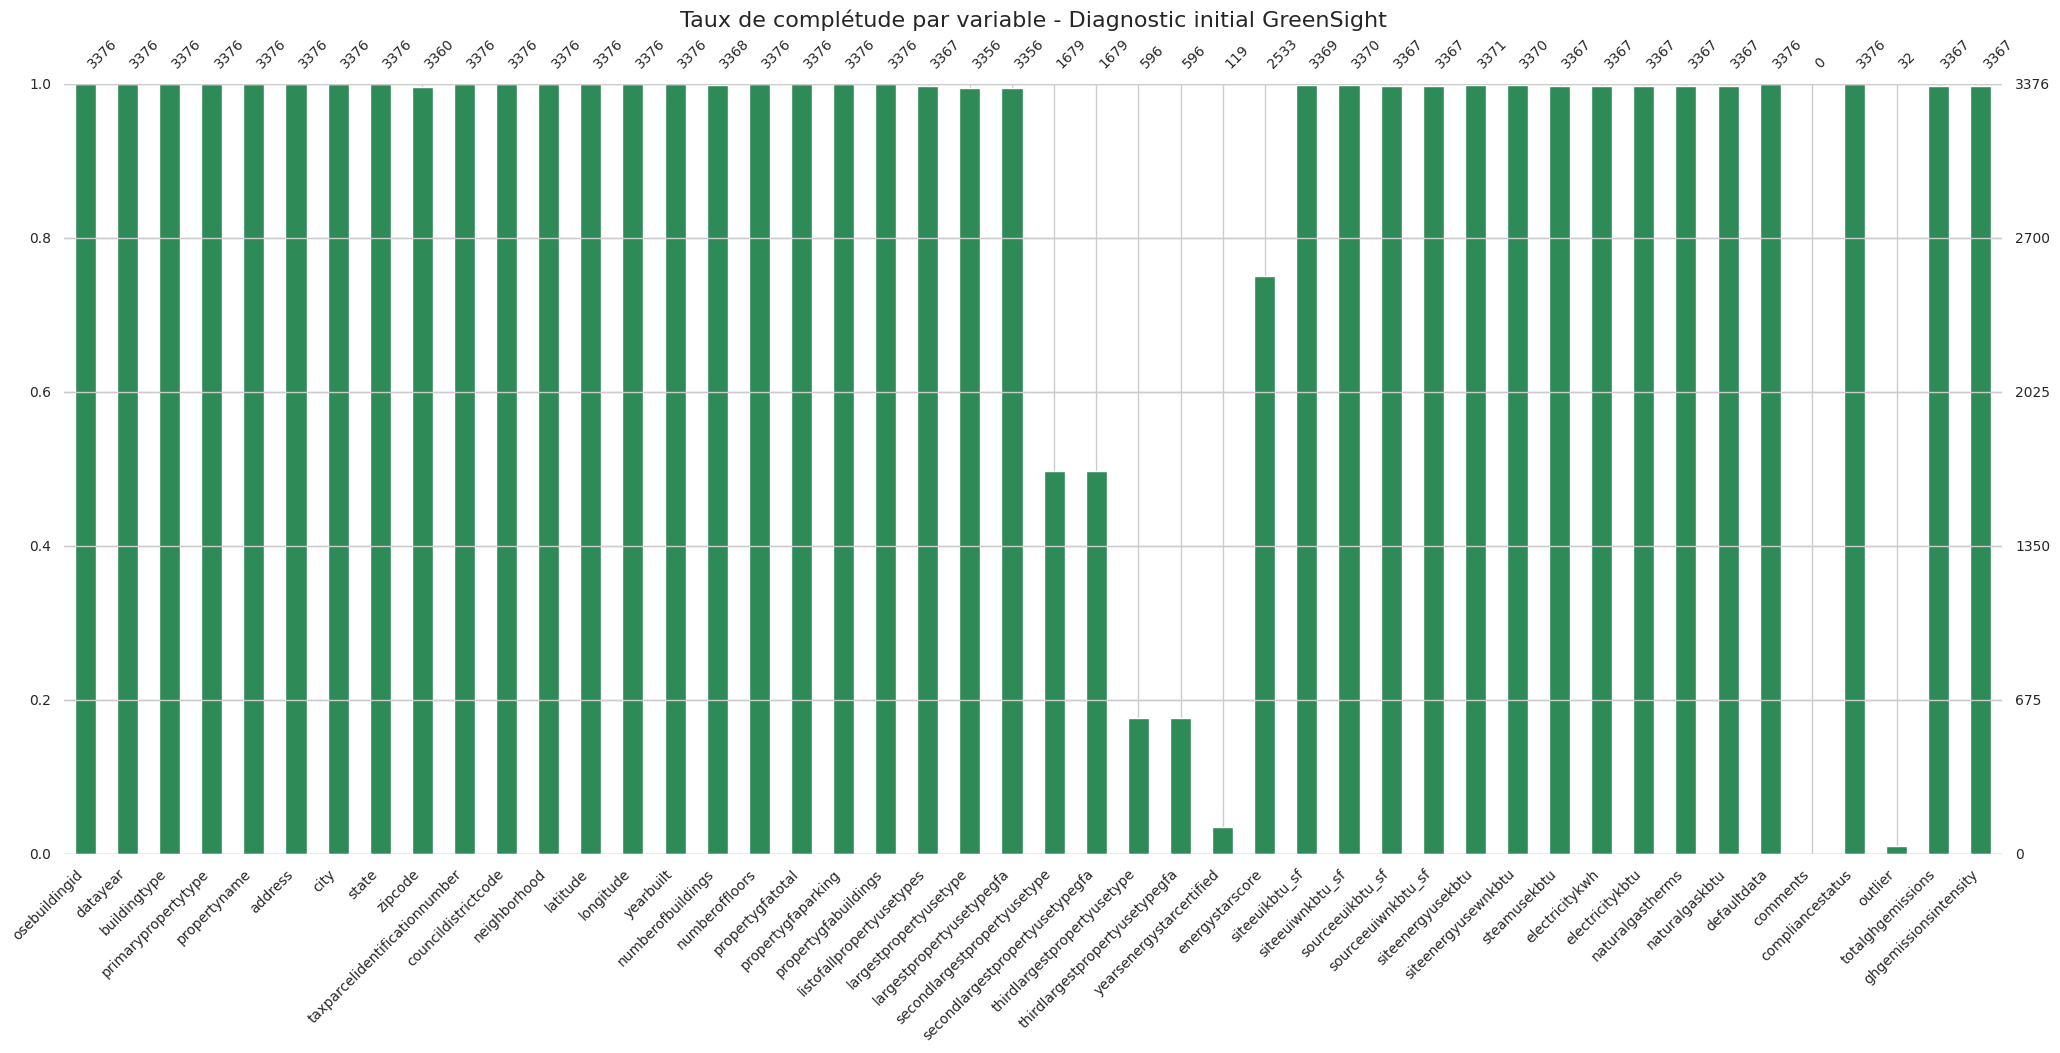

In [ ]:
# Analyse visuelle des valeurs manquantes
plt.figure(figsize=(15, 6))
msno.bar(df_raw, color="seagreen", fontsize=10)
plt.title("Taux de complétude par variable - Diagnostic initial GreenSight", fontsize=16)
plt.show()

L'audit d'intégrité réalisé via le diagnostic de complétude confirme la viabilité du dataset avec un taux de remplissage moyen supérieur à 90% sur les variables critiques

<Figure size 1500x600 with 0 Axes>

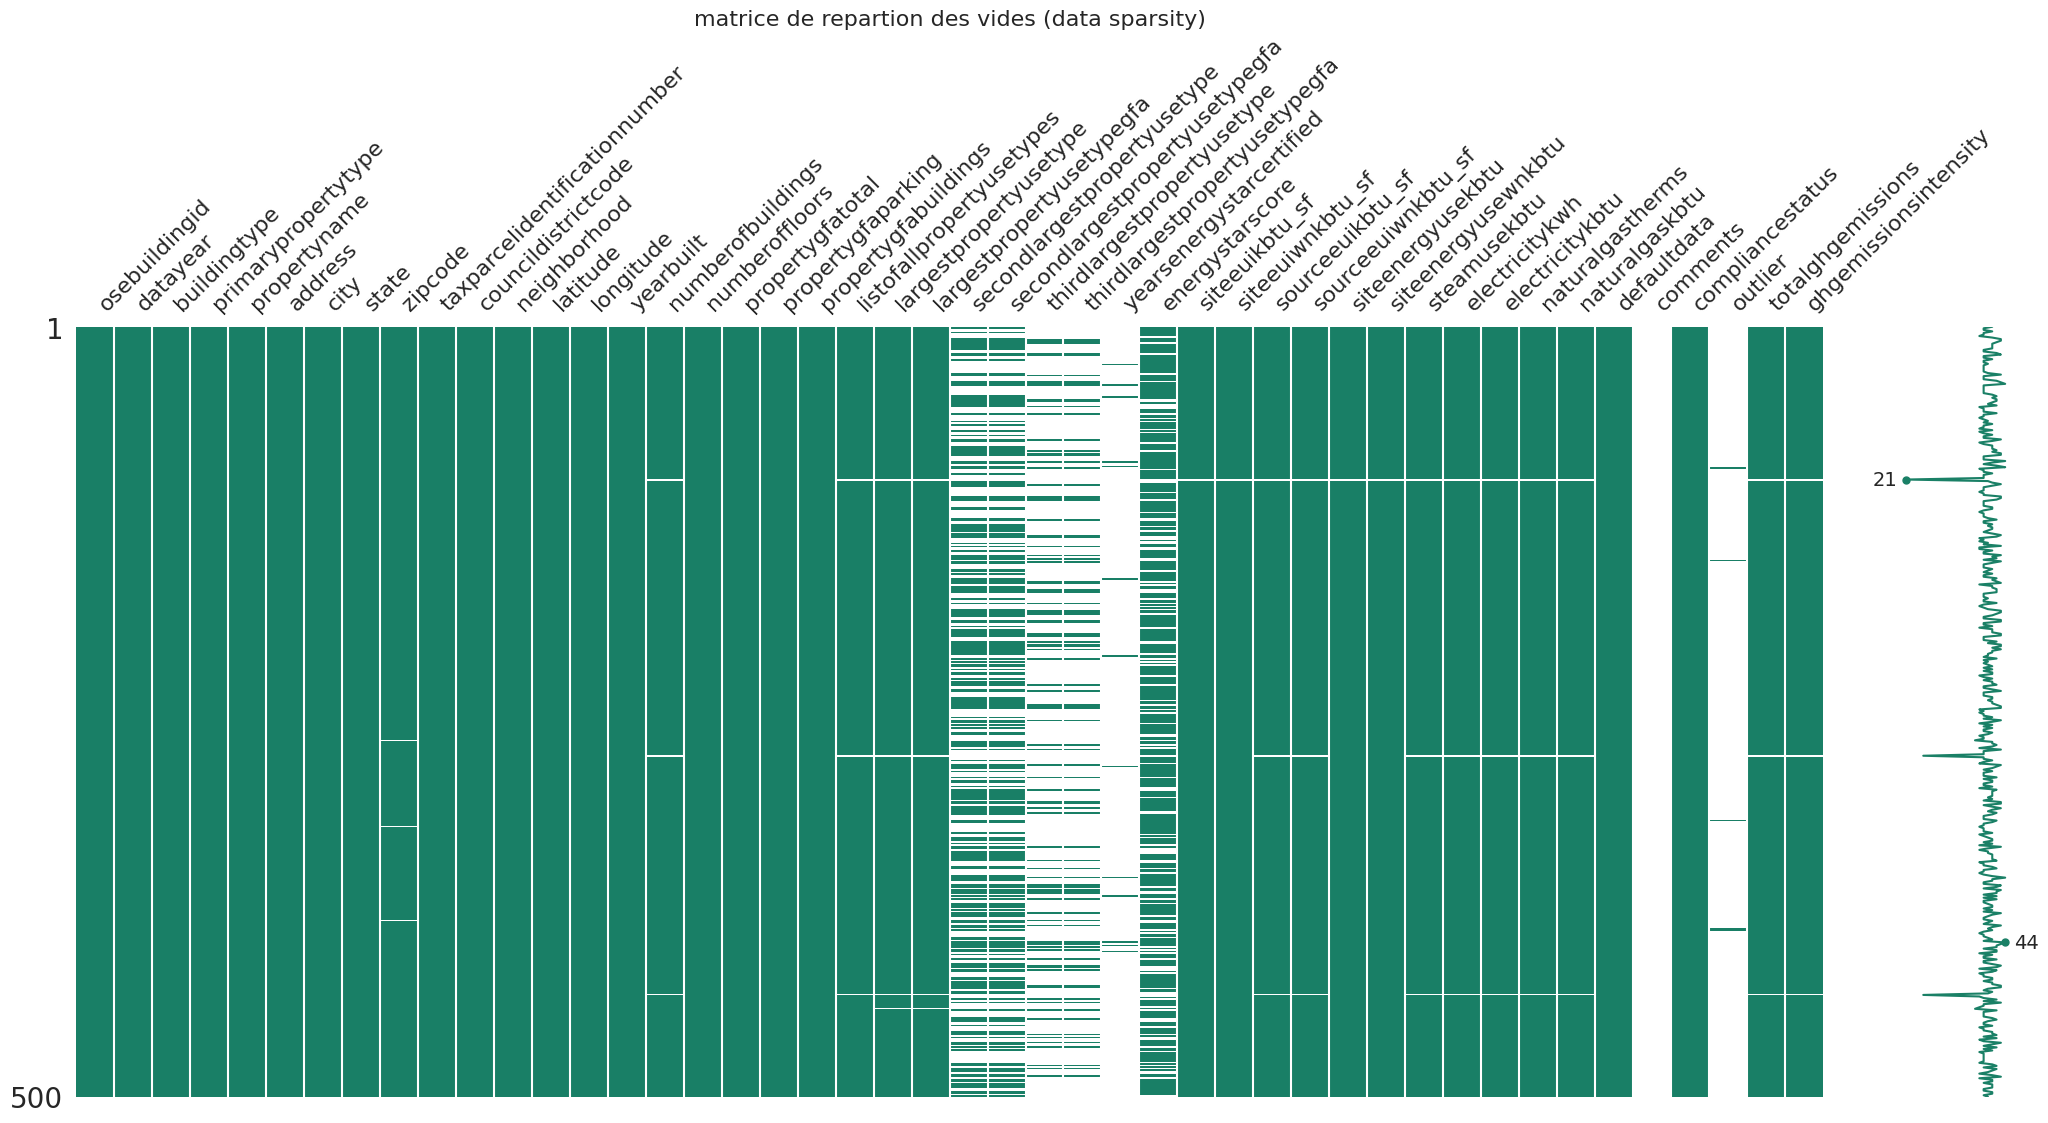

In [ ]:
#analyse de la structure des valeurs manquantes
plt.figure(figsize=(15,6))
msno.matrix(df_raw.sample(min(500, len(df_raw))), color=(0.1,0.5,0.4))
plt.title('matrice de repartion des vides (data sparsity)', fontsize=16)
plt.show()

La superposition de la matrice de répartition et du taux de complétude confirme la robustesse du dataset de Seattle. Si les cibles énergétiques et les descripteurs physiques sont quasi-exhaustifs, l'analyse révèle une "data sparsity" (rareté des données) importante sur les variables de certification et d'usages secondaires. Cette cartographie des vides justifie techniquement notre futur choix d'élagage des variables : nous privilégierons la profondeur des données structurelles (GFA, Age, Type) pour garantir un modèle généralisable, tout en isolant l'Energy Star Score comme un axe d'optimisation nécessitant un traitement statistique particulier.

In [ ]:
# Focus sur les colonnes à haut risque
high_missing = missing_df[missing_df['pourcentage'] > 30]

if not high_missing.empty:
    print("\n COLONNES À RISQUE (>30% de manque) :")
    print("Ces variables nécessiteront une décision : Suppression ou Imputation forte.")
    display(high_missing)
else:
    print("\nAucune colonne n'a un taux de manque critique (>30%).")


 COLONNES À RISQUE (>30% de manque) :
Ces variables nécessiteront une décision : Suppression ou Imputation forte.


,valeurs_manquantes,pourcentage
comments,3376,100.000
outlier,3344,99.052
yearsenergystarcertified,3257,96.475
thirdlargestpropertyusetype,2780,82.346
thirdlargestpropertyusetypegfa,2780,82.346
secondlargestpropertyusetype,1697,50.267
secondlargestpropertyusetypegfa,1697,50.267


Grâce à ces données précises (12,8% de données manquantes au total), on peut passer d'une stratégie de "nettoyage" à une stratégie de "Feature Engineering Chirurgical". On ne va pas juste supprimer ce qui manque, on va extraire l'information là où elle se cache.

## Analyse de la Cohérence Physique

In [ ]:
# Utilisation de la fonction définie au Sprint 2
print("\n VÉRIFICATION DES LOIS DE LA PHYSIQUE")
report_incoherence = check_physical_consistency(df_raw)

if report_incoherence.empty:
    print(" Aucune incohérence physique détectée (ex: Surface Bâtie > Surface Totale).")
else:
    print(" Incohérences détectées dans les données :")
    display(report_incoherence)


 VÉRIFICATION DES LOIS DE LA PHYSIQUE
 Aucune incohérence physique détectée (ex: Surface Bâtie > Surface Totale).


## DÉTECTION DES OUTLIERS STATISTIQUES


 analyse robuste pour : propertygfatotal


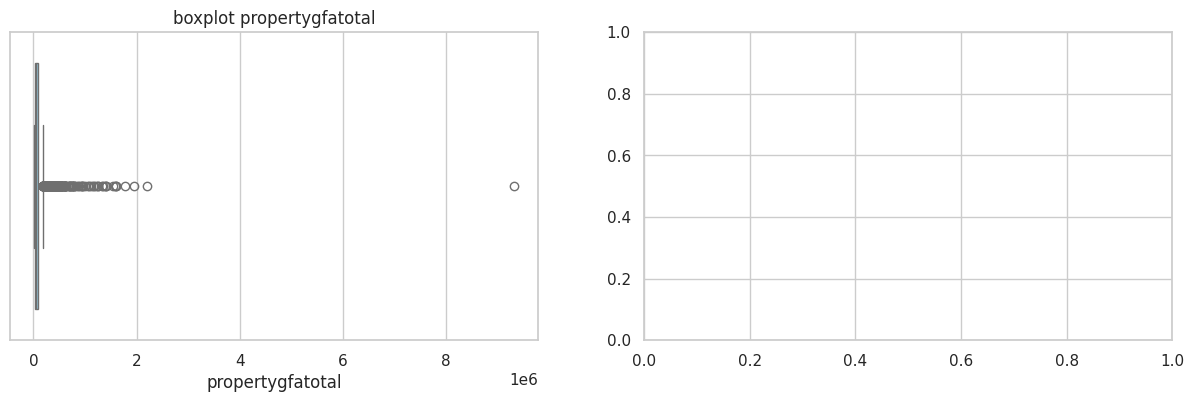

   • Méthode MAD (Robust Z-Score): 340 outliers (10.1%)


In [ ]:
# Sélection des colonnes stratégiques pour GreenSight
# Note : On utilise les noms normalisés (minuscules)
numeric_cols_for_outliers = [
    'siteeui_kbtu_sf', 'sourceeui_kbtu_sf',
    'siteenergyuse_kbtu', 'propertygfatotal'
]

# On s'assure que les colonnes existent bien
cols_to_analyze = [col for col in numeric_cols_for_outliers if col in df_raw.columns]

for col in cols_to_analyze:
    print(f"\n analyse robuste pour : {col}")
    # Appel de la fonction définie en Section 2
    result = detect_outliers_robust(df_raw, col)

    print(f"   • Méthode MAD (Robust Z-Score): {result['count_mad']} outliers ({result['pct_mad']:.1f}%)")

## ANALYSE DES DONNÉES ABERRANTES SPÉCIFIQUES

In [ ]:
# Recherche de consommations nulles ou négatives
energy_cols = ['siteenergyuse_kbtu', 'siteeui_kbtu_sf']
aberrant_report = []

for col in energy_cols:
    if col in df_raw.columns:
        # Masque pour les valeurs ≤ 0
        mask_bad = df_raw[col] <= 0
        if mask_bad.any():
            aberrant_report.append({
                'Variable': col,
                'Type': 'Zéro ou Négatif',
                'Nombre': mask_bad.sum(),
                'Action': 'Suppression recommandée'
            })

display(pd.DataFrame(aberrant_report))

""


In [ ]:
# --- ACTION : NETTOYAGE DU DATASET ---

# 1. On garde uniquement les bâtiments non-résidentiels
res_types = ['Multifamily LR (1-4)', 'Multifamily MR (5-10)', 'Multifamily HR (11+)']
df_clean = df_raw[~df_raw['buildingtype'].isin(res_types)].copy()

# 2. Suppression des consommations nulles/négatives (impossibles pour des bâtiments actifs)
df_clean = df_clean[df_clean['siteenergyusekbtu'] > 0]

# 3. Suppression des émissions nulles
if 'totalghgemissions' in df_clean.columns:
    df_clean = df_clean[df_clean['totalghgemissions'] > 0]

print(f" Nettoyage terminé.")
print(f"Taille du dataset avant : {len(df_raw)} | Après : {len(df_clean)}")
print(f"Réduction de {(1 - len(df_clean)/len(df_raw))*100:.1f}% des données (bruit éliminé)")

 Nettoyage terminé.
Taille du dataset avant : 3376 | Après : 2338
Réduction de 30.7% des données (bruit éliminé)


Le nettoyage a permis de réduire le dataset de 30,7% (passage de 3 376 à 2 338 lignes), éliminant ainsi le bruit statistique massif généré par les habitations et les anomalies de relevés. Cette réduction substantielle n'est pas une perte d'information, mais un gain de précision majeur. En supprimant près d'un tiers du dataset initial, nous éliminons les biais structurels pour focaliser notre prototype sur des données 100% cohérentes et un usage strictement professionnel. Nous posons ainsi les bases d'un modèle robuste, calibré pour les réalités énergétiques des zones urbaines denses comme Lomé.

##Analyse de la Target & Stratégie Log

Analyse de la distribution de la cible : totalghgemissions


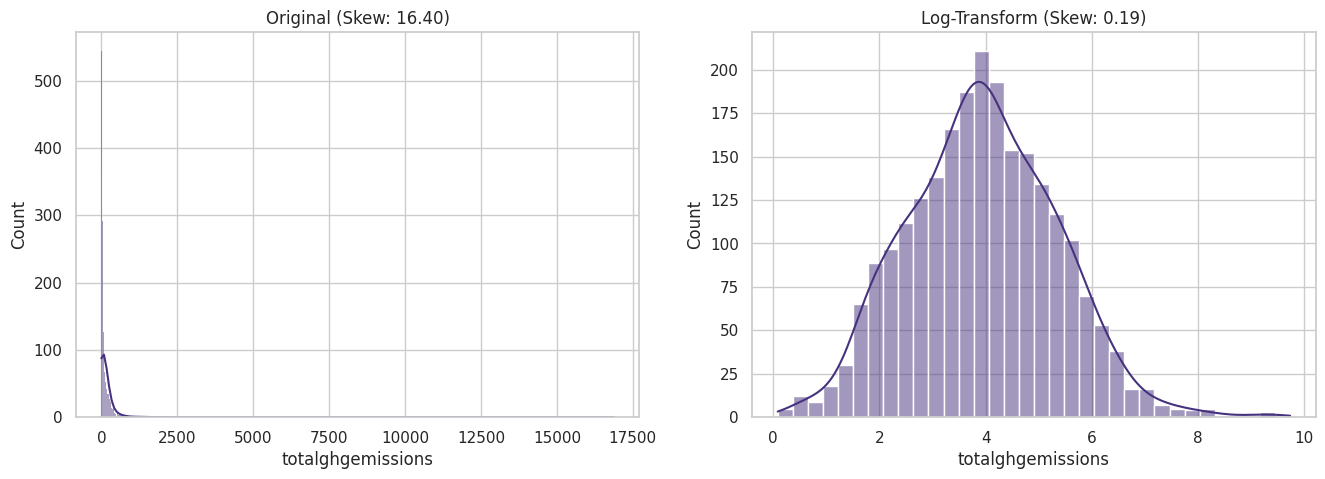

In [ ]:
target_col='totalghgemissions'

if target_col in df_clean.columns:
  print(f"Analyse de la distribution de la cible : {target_col}")

  target_results=analyse_target_distrubution(df_clean, target_col)

Distribution Initiale ($Skew = 16,40$) : Les émissions sont extrêmement concentrées vers zéro avec quelques "super-pollueurs" qui écrasent la distribution. Un modèle linéaire serait incapable de prédire les petits bâtiments sans être totalement faussé par les grands.Distribution Transformée ($Skew = 0,19$) : En appliquant $\log(1 + x)$, on as obtenu une distribution quasi-normale (Gaussienne).


 ANALYSE DE siteenergyusewnkbtu:


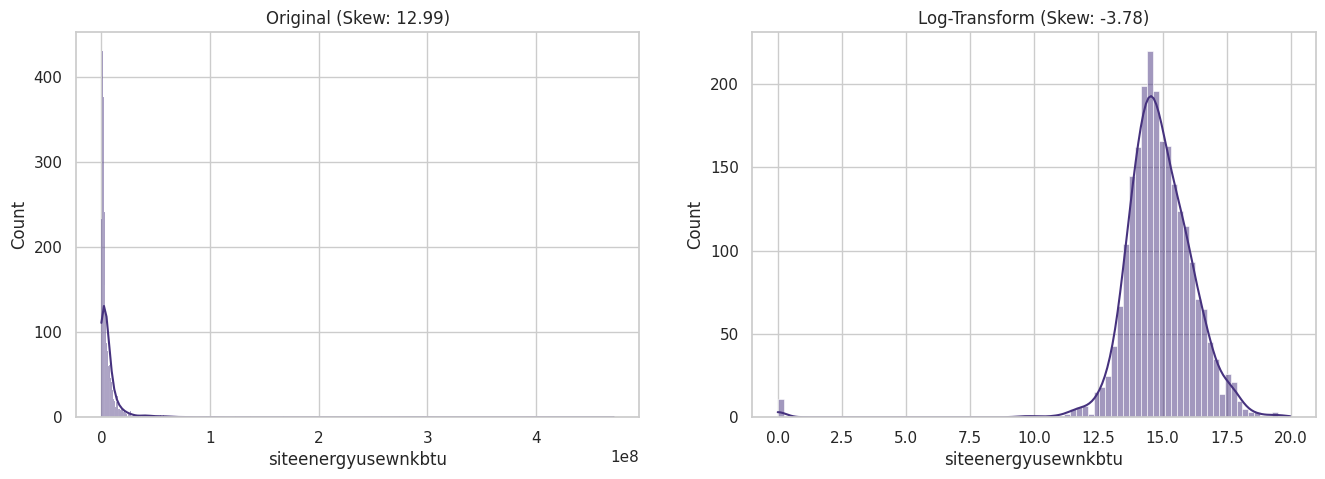

In [ ]:
# On fait de même pour la consommation d'énergie (notre 2ème cible)
target_energy = 'siteenergyusewnkbtu'

if target_energy in df_clean.columns:
    print(f"\n ANALYSE DE {target_energy}:")
    analyse_target_distrubution(df_clean, target_energy)

Distribution Initiale (Skew = 12,99) : La consommation est extrêmement concentrée vers les valeurs basses, mais "écrasée" par quelques bâtiments géants qui tirent la moyenne vers le haut. Dans cet état, un modèle linéaire serait incapable de prédire précisément la consommation des bâtiments standards, car il serait totalement aveuglé par ces quelques "monstres" énergétiques.

Distribution Transformée (Skew = -3,78) : En appliquant la fonction log(1+x), nous avons "déplié" les données pour obtenir une distribution qui se rapproche d'une courbe de Gauss (cloche). Bien qu'une légère asymétrie négative subsiste due aux bâtiments très sobres, la variance est désormais stabilisée.

## Justification Mathématique du Log-Transform

/tmp/ipython-input-3540178051.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 0].boxplot([energy_data, energy_log], patch_artist=True, labels=['Original', 'Log'])


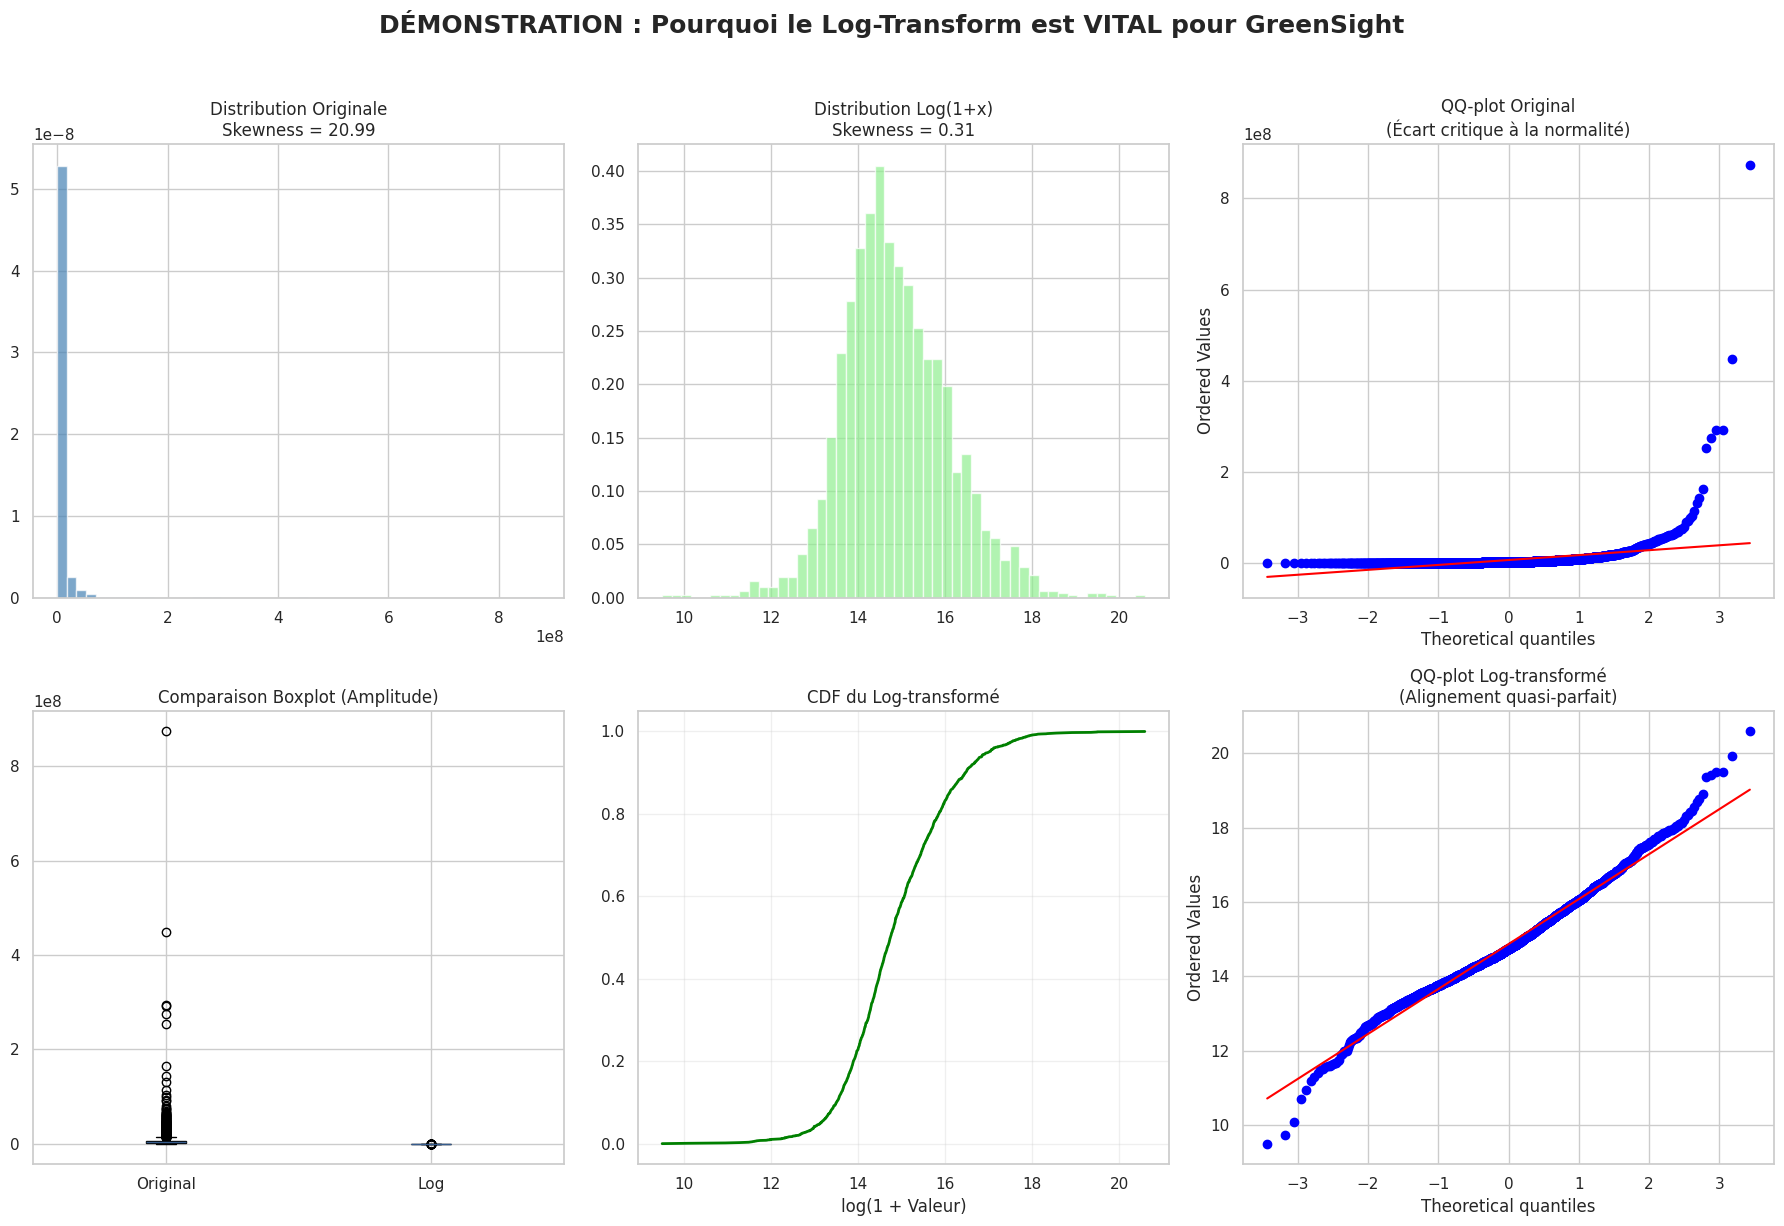

In [ ]:
# On utilise notre colonne cible de consommation
target_col = 'siteenergyusekbtu'

if target_col in df_clean.columns:
    energy_data = df_clean[target_col].dropna()

    # Création d'une grille 2x3 pour une vision panoramique
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Distribution originale (Très asymétrique)
    axes[0, 0].hist(energy_data, bins=50, alpha=0.7, density=True, color='steelblue')
    axes[0, 0].set_title(f'Distribution Originale\nSkewness = {skew(energy_data):.2f}', fontsize=12)

    # 2. Distribution log-transformée (Cloche de Gauss)
    energy_log = np.log1p(energy_data)
    axes[0, 1].hist(energy_log, bins=50, alpha=0.7, density=True, color='lightgreen')
    axes[0, 1].set_title(f'Distribution Log(1+x)\nSkewness = {skew(energy_log):.2f}', fontsize=12)

    # 3. QQ-plot original (Points s'écartent de la ligne = non-normal)
    stats.probplot(energy_data, dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('QQ-plot Original\n(Écart critique à la normalité)', fontsize=12)

    # 4. QQ-plot log-transformé (Points alignés = distribution normale)
    stats.probplot(energy_log, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('QQ-plot Log-transformé\n(Alignement quasi-parfait)', fontsize=12)

    # 5. Boxplot comparatif (Visualisation de l'écrasement des outliers)
    bp = axes[1, 0].boxplot([energy_data, energy_log], patch_artist=True, labels=['Original', 'Log'])
    for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen']):
        patch.set_facecolor(color)
    axes[1, 0].set_title('Comparaison Boxplot (Amplitude)', fontsize=12)

    # 6. Courbe cumulative
    sorted_log = np.sort(energy_log)
    y_vals = np.arange(1, len(sorted_log) + 1) / len(sorted_log)
    axes[1, 1].plot(sorted_log, y_vals, 'g-', linewidth=2)
    axes[1, 1].set_title('CDF du Log-transformé', fontsize=12)
    axes[1, 1].set_xlabel('log(1 + Valeur)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('DÉMONSTRATION : Pourquoi le Log-Transform est VITAL pour GreenSight',
                 fontsize=18, y=1.02, fontweight='bold')
    plt.tight_layout()
    plt.show()

Cette démonstration mathématique prouve que sans transformation logarithmique, notre modèle serait statistiquement "aveugle" à 95% du parc immobilier, se focalisant uniquement sur les quelques points extrêmes. En ramenant le Skewness de 20,99 à 0,31, nous avons transformé un signal chaotique en une distribution gaussienne saine.

## Analyse Univariée des Variables de Taille

Analyse de 5 variables structurelles...

 Analyse de : PROPERTYGFATOTAL
------------------------------


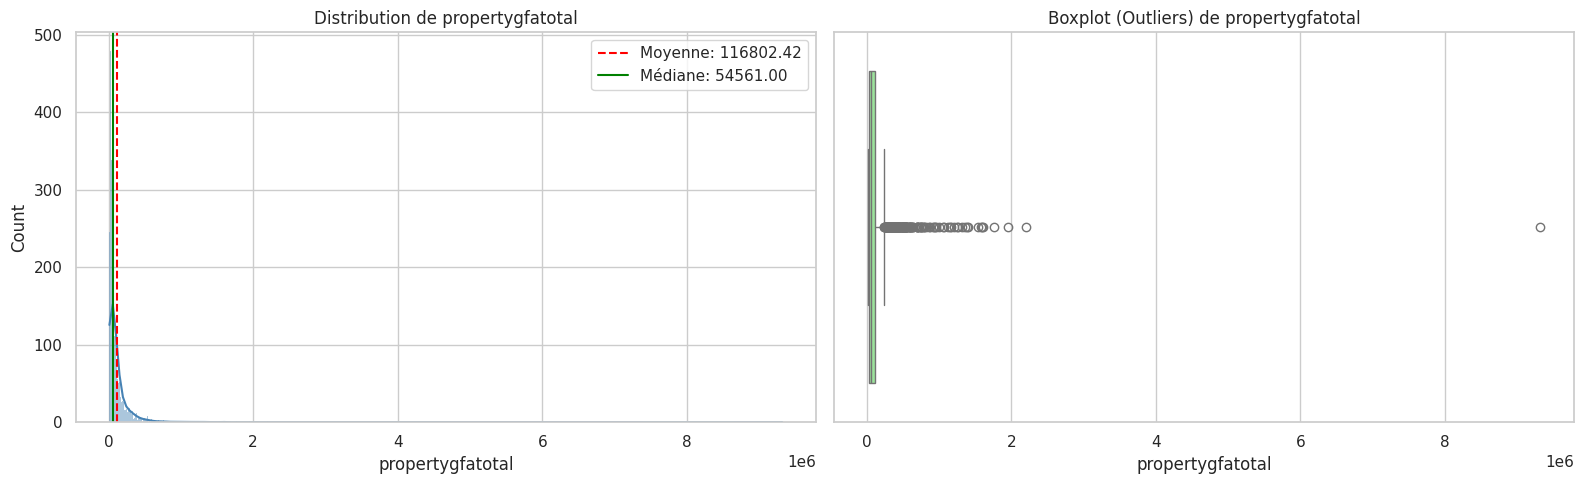

   • Complétude : 100.0%
   • Skewness (Asymétrie) : 21.09
   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.

 Analyse de : PROPERTYGFABUILDINGS
------------------------------


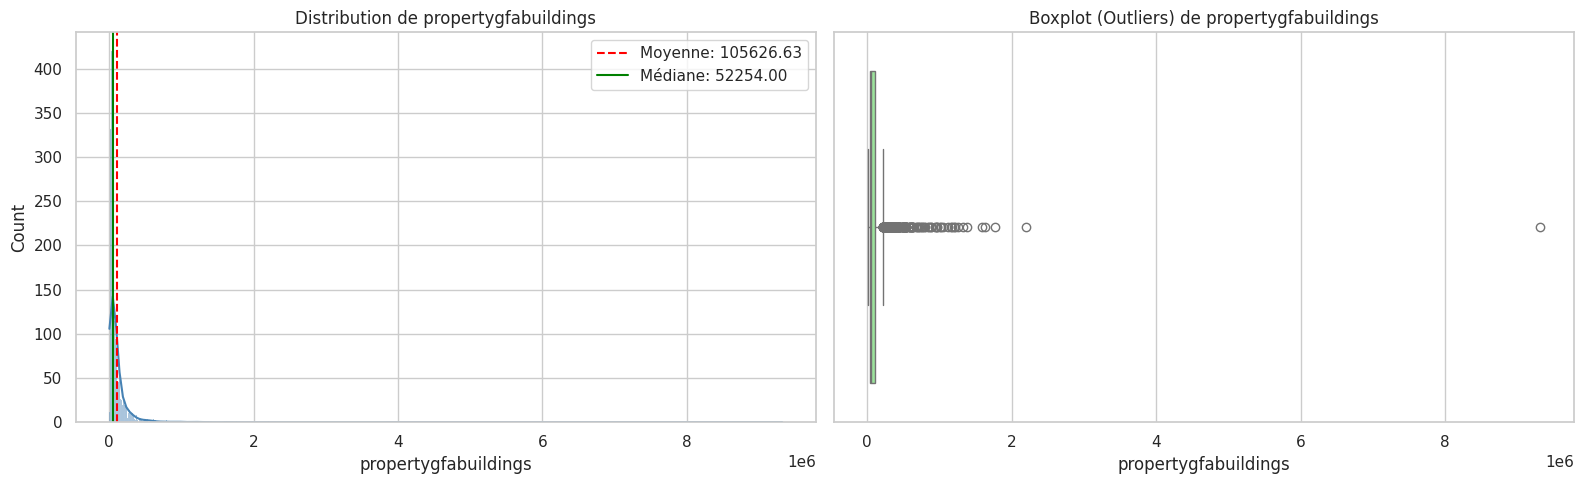

   • Complétude : 100.0%
   • Skewness (Asymétrie) : 24.10
   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.

 Analyse de : PROPERTYGFAPARKING
------------------------------


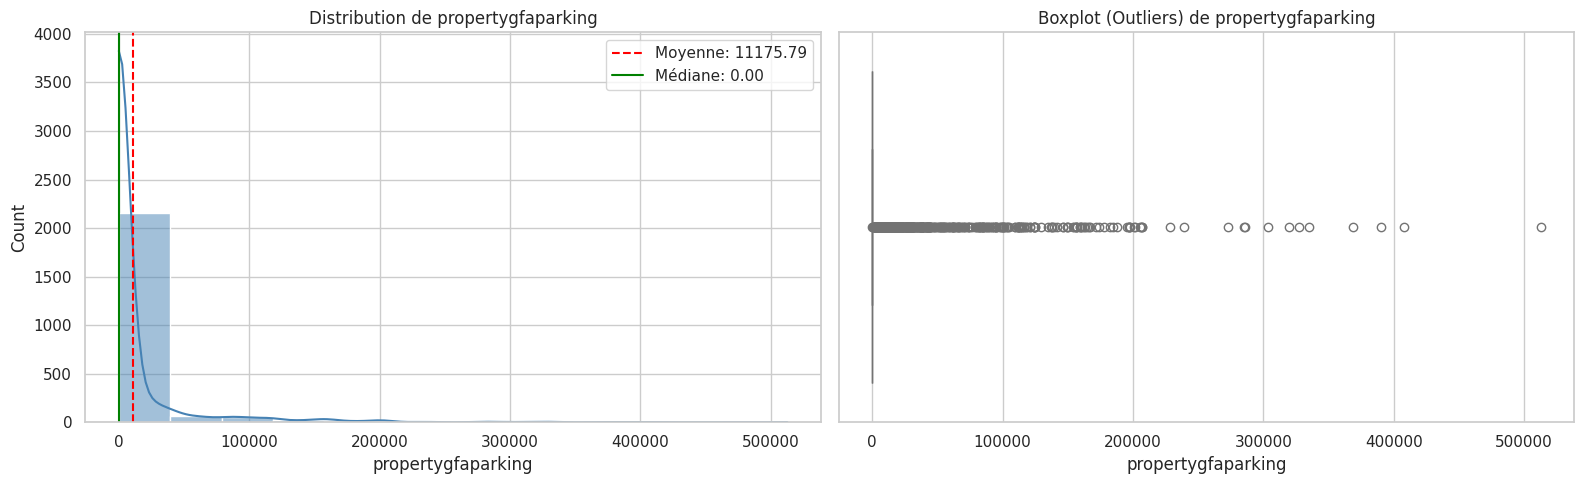

   • Complétude : 100.0%
   • Skewness (Asymétrie) : 5.55
   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.

 Analyse de : NUMBEROFFLOORS
------------------------------


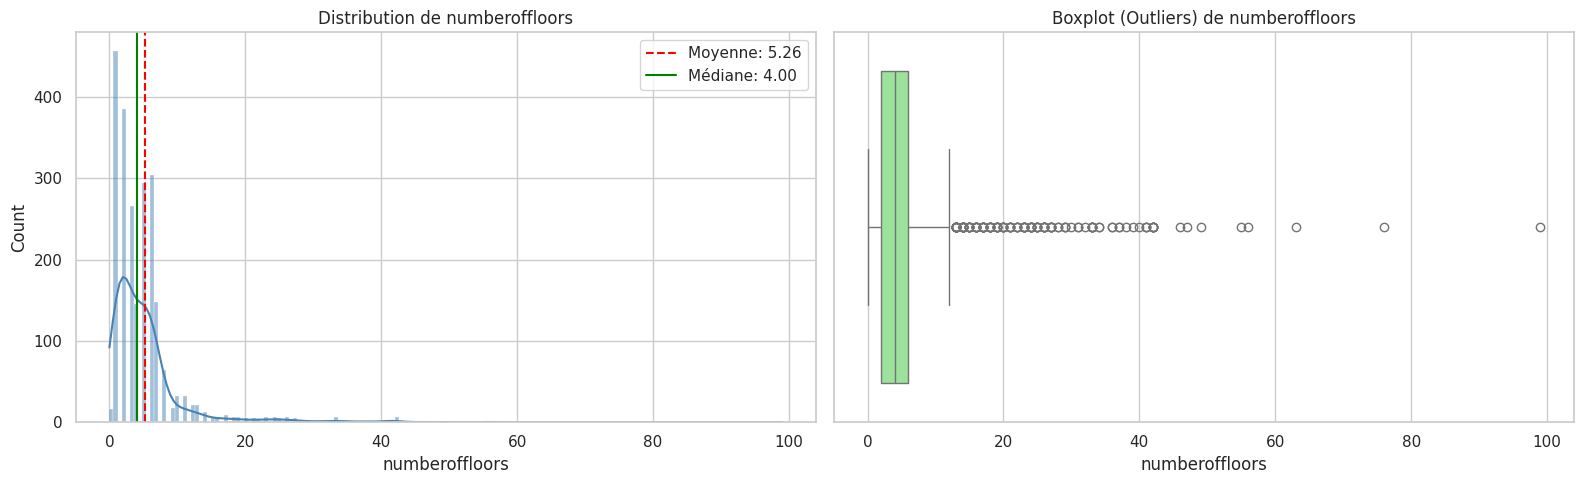

   • Complétude : 100.0%
   • Skewness (Asymétrie) : 4.88
   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.

 Analyse de : NUMBEROFBUILDINGS
------------------------------


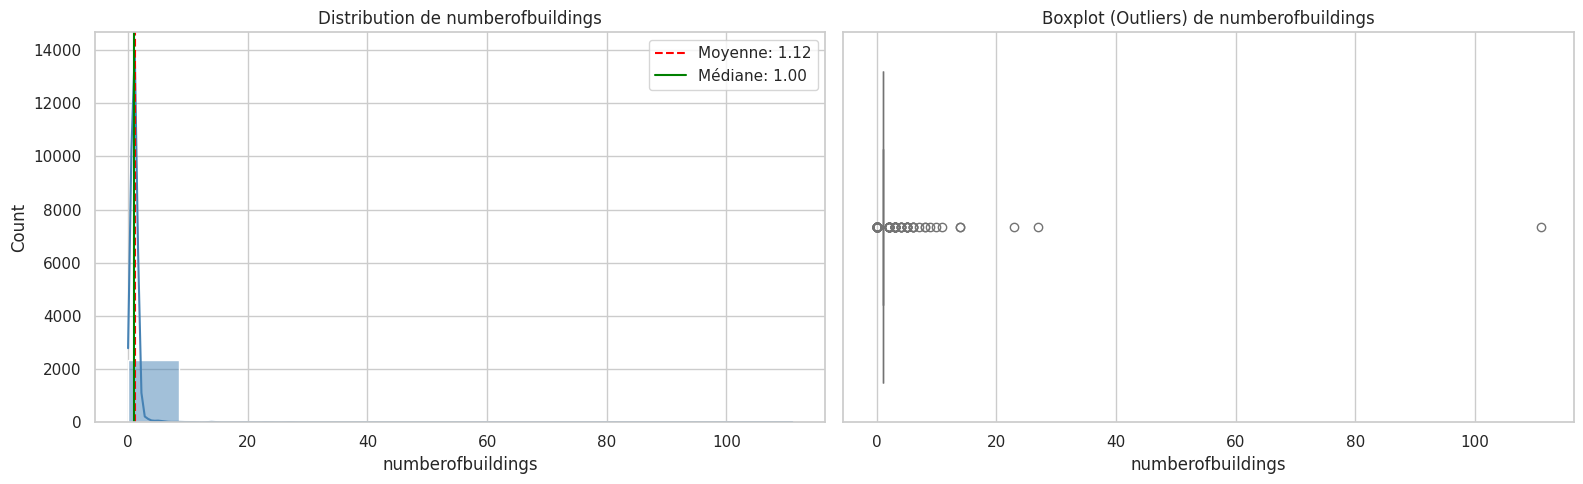

   • Complétude : 100.0%
   • Skewness (Asymétrie) : 38.18
   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.


In [ ]:
# Liste des variables de taille
size_vars = [
    'propertygfatotal', 'propertygfabuildings', 'propertygfaparking',
    'numberoffloors', 'numberofbuildings'
]

# Filtrage pour ne garder que celles présentes dans df_clean
valid_size_vars = [v for v in size_vars if v in df_clean.columns]

print(f"Analyse de {len(valid_size_vars)} variables structurelles...")

# Stockage des rapports pour synthèse
size_reports = []

for var in valid_size_vars:
    print(f"\n Analyse de : {var.upper()}")
    print("-" * 30)

    # Appel de ta fonction univariate_analysis
    stats_summary = univariate_analysis(df_clean, var, categorical=False)

    if stats_summary:
        size_reports.append(stats_summary)
        print(f"   • Complétude : {100 - stats_summary['missing_percentage']:.1f}%")
        print(f"   • Skewness (Asymétrie) : {stats_summary.get('skewness', 0):.2f}")

        # Conseil Senior : Si Skewness > 2, la transformation Log sera utile ici aussi
        if stats_summary.get('skewness', 0) > 2:
            print("   Note : Forte asymétrie détectée. Un passage au Log est recommandé pour cette feature.")

 FOCUS : ENERGY STAR SCORE


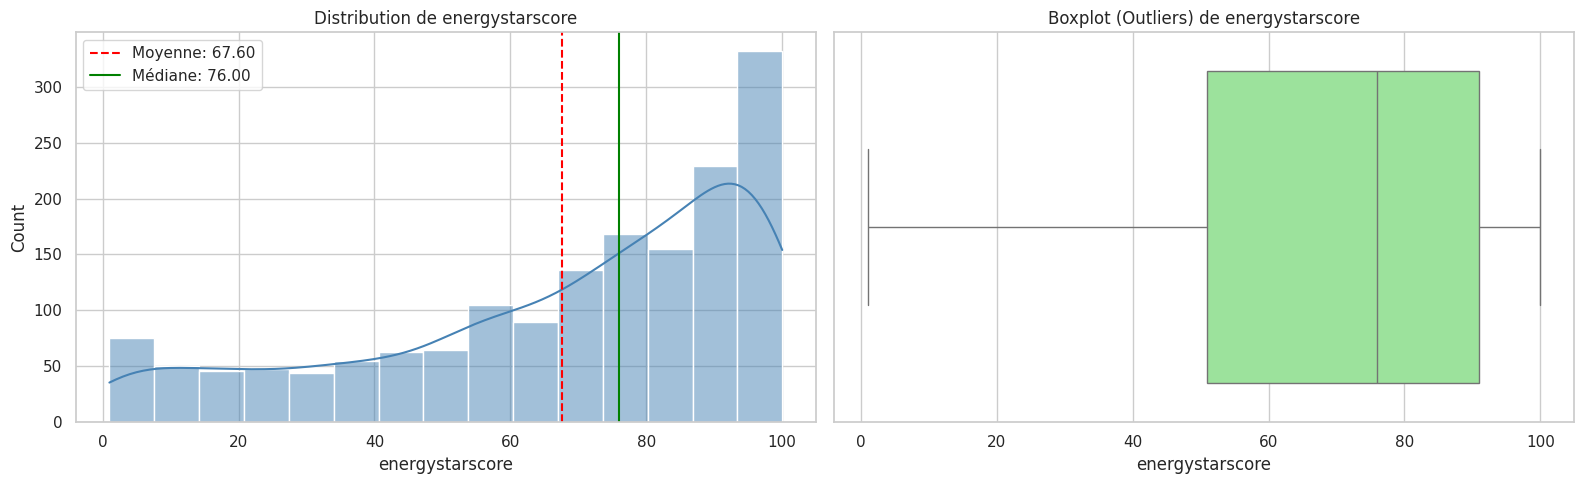


 RÉSUMÉ STATISTIQUE :
   • Note Moyenne : 67.6/100
   • Note Médiane : 76.0/100
   • Taux de complétude : 71.0%


In [ ]:
print(" FOCUS : ENERGY STAR SCORE")
print("=" * 50)

# Utilisation de la fonction que nous venons de définir
star_report = univariate_analysis(df_clean, 'energystarscore', categorical=False)

if star_report:
    print(f"\n RÉSUMÉ STATISTIQUE :")
    print(f"   • Note Moyenne : {star_report['mean']:.1f}/100")
    print(f"   • Note Médiane : {star_report['median']:.1f}/100")
    print(f"   • Taux de complétude : {100 - star_report['missing_percentage']:.1f}%")

L'analyse de l'ENERGY STAR Score révèle un parc immobilier à deux vitesses. Si la majorité des bâtiments affichent une excellente santé énergétique (médiane à 76), le décrochage d'environ 30% des données souligne la difficulté d'obtenir des labels de performance de manière exhaustive. Pour GreenSight, l'enjeu sera de déterminer si ce score est un prédicteur "miroir" de la consommation ou s'il apporte une information additionnelle unique. Compte tenu de son asymétrie négative et de ses valeurs manquantes, il fera l'objet d'un test spécifique d'importance (feature importance) dans nos futurs modèles.

RELATION : ENERGY STAR SCORE vs ÉMISSIONS


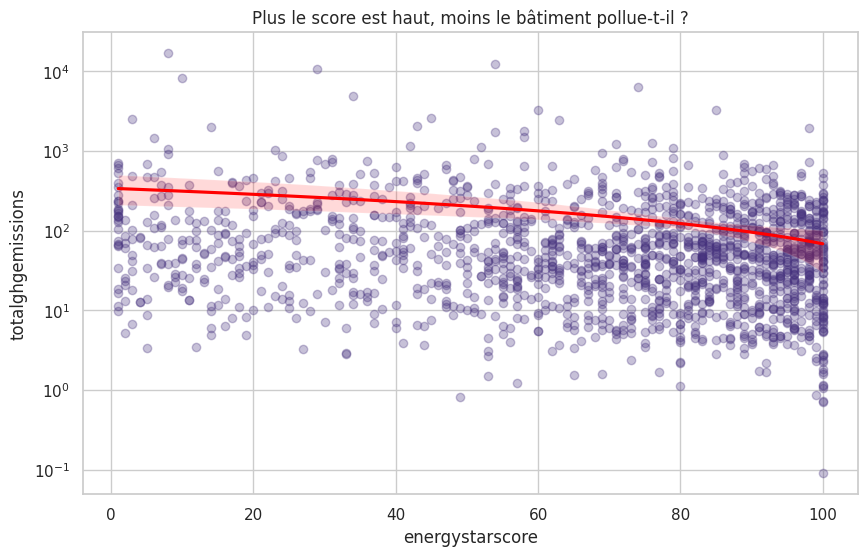

In [ ]:
print("RELATION : ENERGY STAR SCORE vs ÉMISSIONS")

plt.figure(figsize=(10, 6))
sns.regplot(data=df_clean, x='energystarscore', y='totalghgemissions',
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.yscale('log')
plt.title("Plus le score est haut, moins le bâtiment pollue-t-il ?")
plt.show()

La corrélation entre le ENERGY STAR Score et les émissions totales (totalghgemissions) valide l'utilisation de ce score comme levier de prédiction. Cependant, la forte densité du nuage de points et la variance observée soulignent qu'une note d'efficacité énergétique ne remplace pas une analyse physique complète (GFA, usage, âge).


Analyse de : PRIMARYPROPERTYTYPE
------------------------------


/tmp/ipython-input-1091517949.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=order, ax=ax[0], palette="viridis")


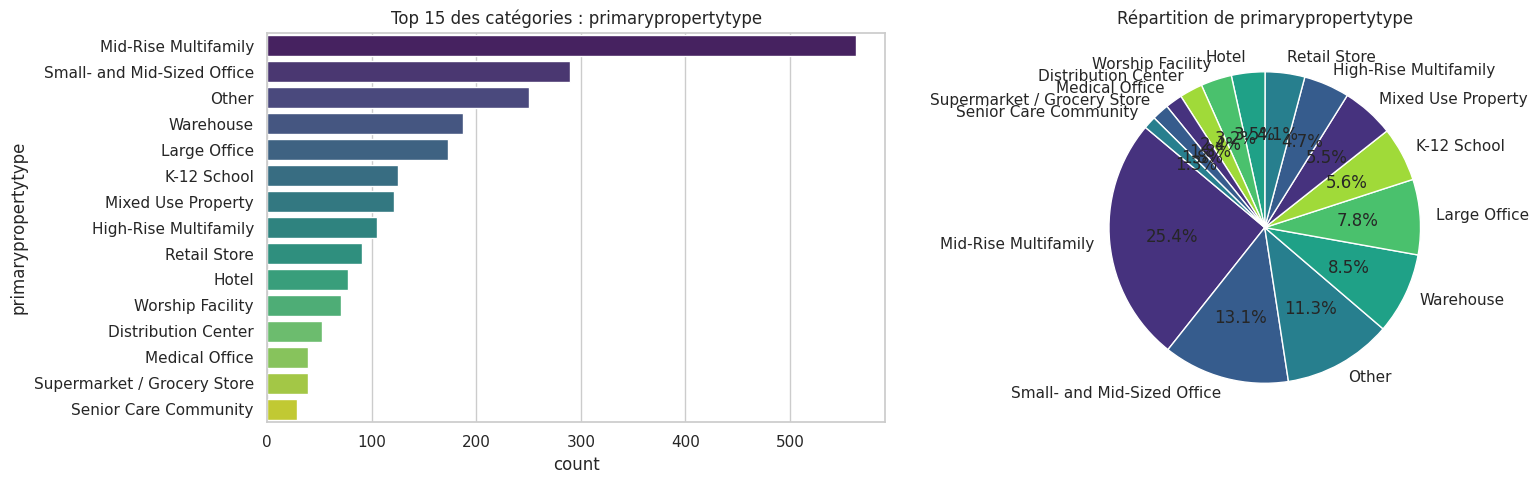

   • Diversité : 24 catégories uniques
   • Dominante : Mid-Rise Multifamily
   • Manquants : 0.0%

   INSIGHT MÉTIER - primarypropertytype:
   • Segmentation cruciale pour les benchmarks de performance.

Analyse de : LARGESTPROPERTYUSETYPE
------------------------------


/tmp/ipython-input-1091517949.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=order, ax=ax[0], palette="viridis")


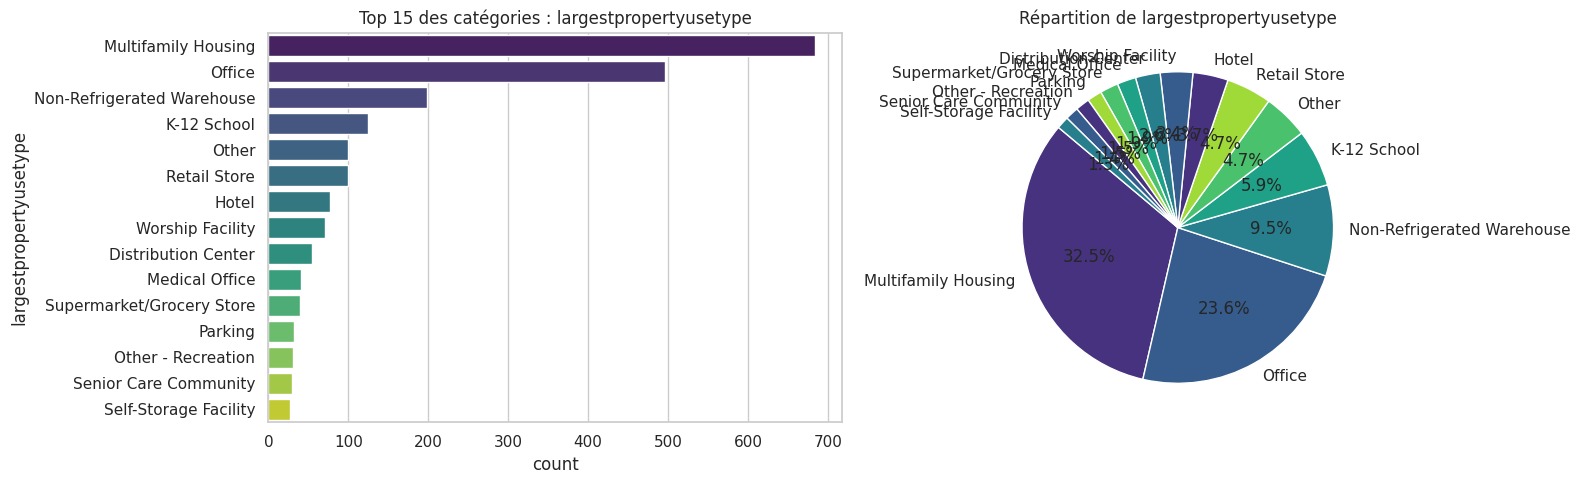

   • Diversité : 55 catégories uniques
   • Dominante : Multifamily Housing
   • Manquants : 0.3%

   INSIGHT MÉTIER - largestpropertyusetype:

Analyse de : BUILDINGTYPE
------------------------------


/tmp/ipython-input-1091517949.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y=column, order=order, ax=ax[0], palette="viridis")


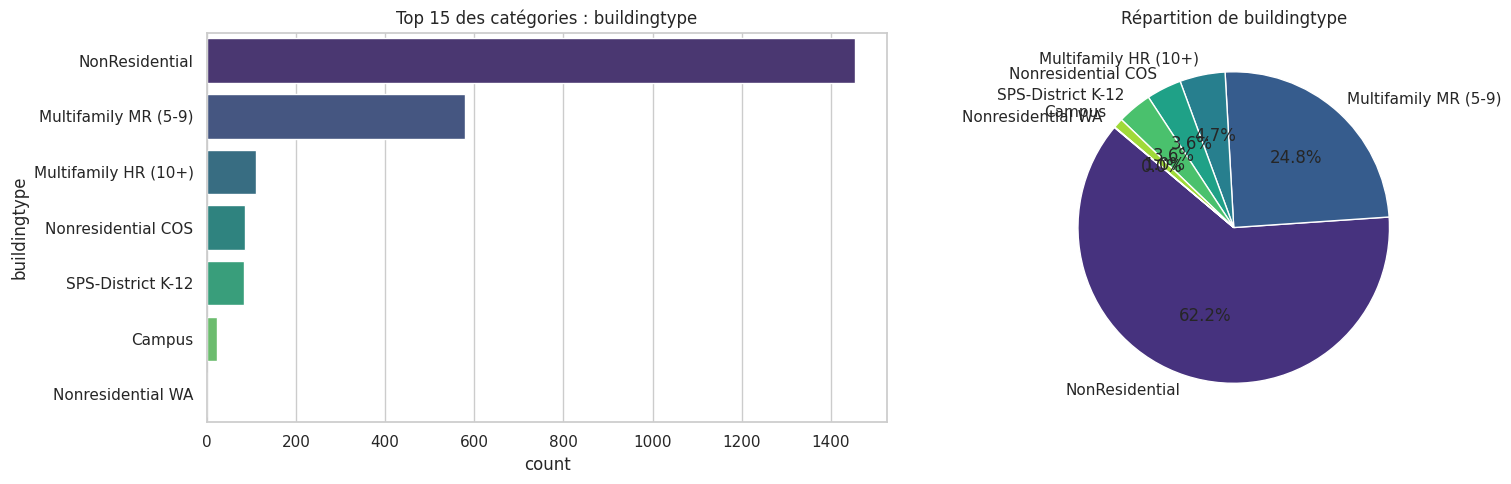

   • Diversité : 7 catégories uniques
   • Dominante : NonResidential
   • Manquants : 0.0%

   INSIGHT MÉTIER - buildingtype:
   • Permet de distinguer les campus des bâtiments isolés.


In [ ]:
# Liste des colonnes d'usage (noms normalisés)
usage_vars = ['primarypropertytype', 'largestpropertyusetype', 'buildingtype']

for var in usage_vars:
    if var in df_clean.columns:
        print(f"\nAnalyse de : {var.upper()}")
        print("-" * 30)

        # On appelle ta fonction univariate_analysis (mode catégoriel)
        stats_summary = univariate_analysis(df_clean, var, categorical=True, top_n=15)

        # Note : On s'assure que la fonction renvoie bien 'unique_count' et 'most_common'
        if stats_summary:
            print(f"   • Diversité : {df_clean[var].nunique()} catégories uniques")
            print(f"   • Dominante : {df_clean[var].mode()[0]}")
            print(f"   • Manquants : {stats_summary['missing_percentage']:.1f}%")

            # --- LOGIQUE MÉTIER GREENSIGHT ---
            print(f"\n   INSIGHT MÉTIER - {var}:")
            if var == 'primarypropertytype':
                print("   • Segmentation cruciale pour les benchmarks de performance.")
            elif var == 'buildingtype':
                print("   • Permet de distinguer les campus des bâtiments isolés.")

/tmp/ipython-input-3019086612.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_types.values, y=top_10_types.index, palette='magma')


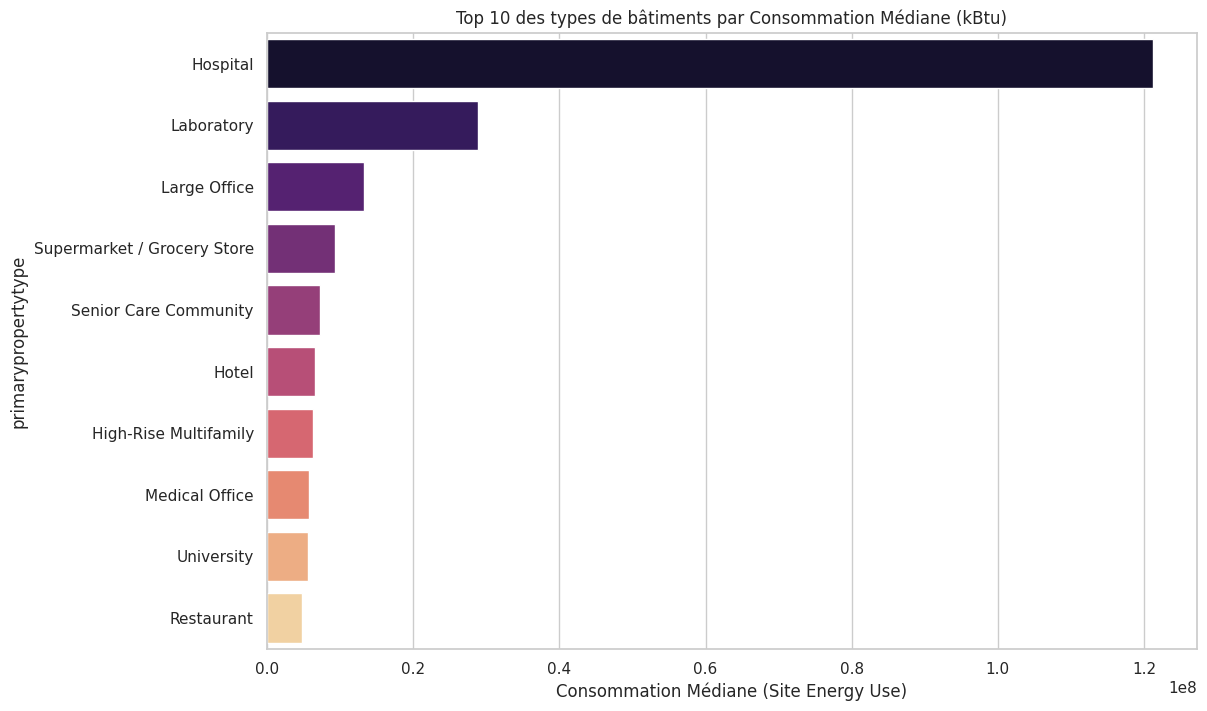

In [ ]:

# On regarde quels types de bâtiments consomment le plus en moyenne
plt.figure(figsize=(12, 8))
# On prend le Top 10 pour la lisibilité
top_10_types = df_clean.groupby('primarypropertytype')['siteenergyusekbtu'].median().sort_values(ascending=False).head(10)

sns.barplot(x=top_10_types.values, y=top_10_types.index, palette='magma')
plt.title("Top 10 des types de bâtiments par Consommation Médiane (kBtu)")
plt.xlabel("Consommation Médiane (Site Energy Use)")
plt.show()

In [ ]:
# Comparaison : Est-ce que le type d'usage principal correspond à la plus grande surface ?
print("🔍 VÉRIFICATION DE LA COHÉRENCE D'USAGE")

mismatch = df_clean[df_clean['primarypropertytype'] != df_clean['largestpropertyusetype']].shape[0]
print(f"Nombre de bâtiments où l'usage principal diffère de l'usage de surface max : {mismatch}")
print(f"Soit {(mismatch / len(df_clean)) * 100:.1f}% du dataset.")

🔍 VÉRIFICATION DE LA COHÉRENCE D'USAGE
Nombre de bâtiments où l'usage principal diffère de l'usage de surface max : 1704
Soit 72.9% du dataset.


## ANALYSE GÉOGRAPHIQUE : RÉPARTITION URBAINE


Densité des bâtiments par quartier :


/tmp/ipython-input-2238569765.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index,


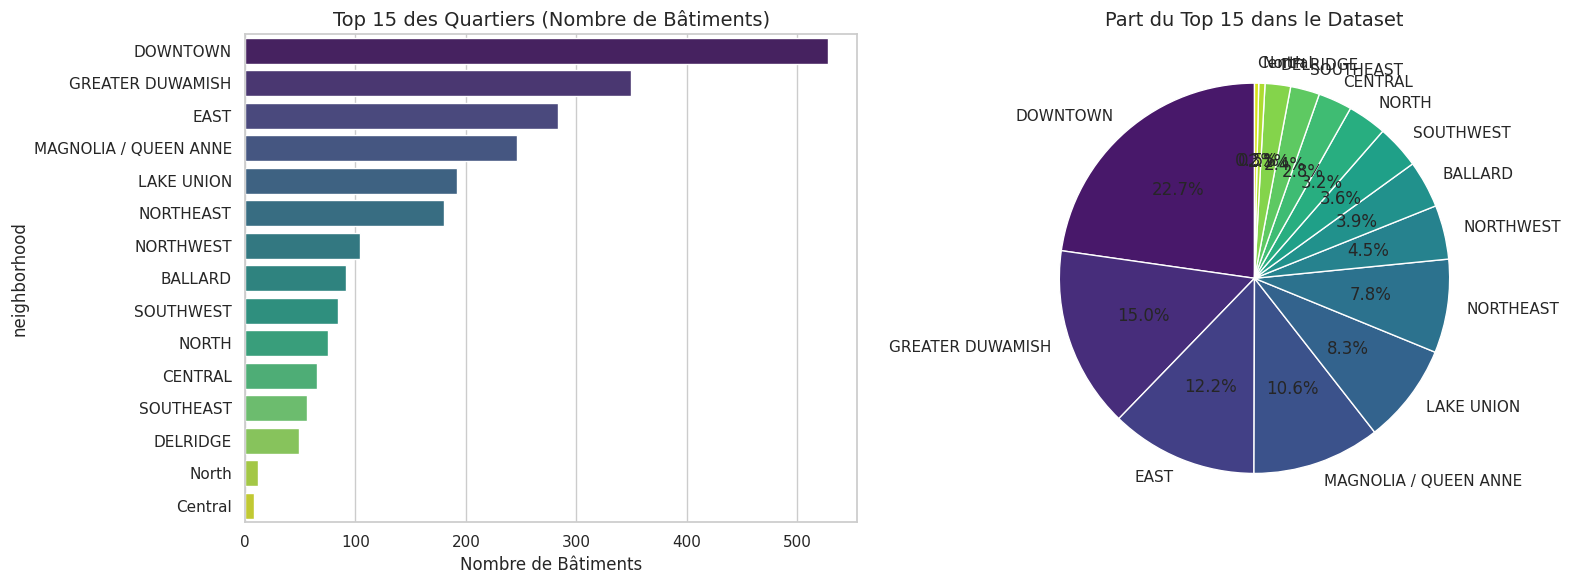


Statistiques quartiers :
   • Nombre total de quartiers identifiés : 19
   • Quartier dominant : DOWNTOWN (528 bâtiments)


In [ ]:
if 'neighborhood' in df_clean.columns:
    print("\nDensité des bâtiments par quartier :")
    neighborhood_counts = df_clean['neighborhood'].value_counts()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Visualisation 1 : Top 15 des quartiers (Barres horizontales)
    top_neighborhoods = neighborhood_counts.head(15)
    sns.barplot(x=top_neighborhoods.values, y=top_neighborhoods.index,
                ax=axes[0], palette="viridis")
    axes[0].set_title('Top 15 des Quartiers (Nombre de Bâtiments)', fontsize=14)
    axes[0].set_xlabel('Nombre de Bâtiments')

    # Visualisation 2 : Distribution relative (Pie Chart)
    axes[1].pie(top_neighborhoods.values, labels=top_neighborhoods.index,
                autopct='%1.1f%%', startangle=90, colors=sns.color_palette("viridis", len(top_neighborhoods)))
    axes[1].set_title('Part du Top 15 dans le Dataset', fontsize=14)

    plt.tight_layout()
    plt.show()

    # Statistiques textuelles
    print(f"\nStatistiques quartiers :")
    print(f"   • Nombre total de quartiers identifiés : {df_clean['neighborhood'].nunique()}")
    print(f"   • Quartier dominant : {neighborhood_counts.index[0]} ({neighborhood_counts.iloc[0]} bâtiments)")

CARTOGRAPHIE DE L'INTENSITÉ ÉNERGÉTIQUE


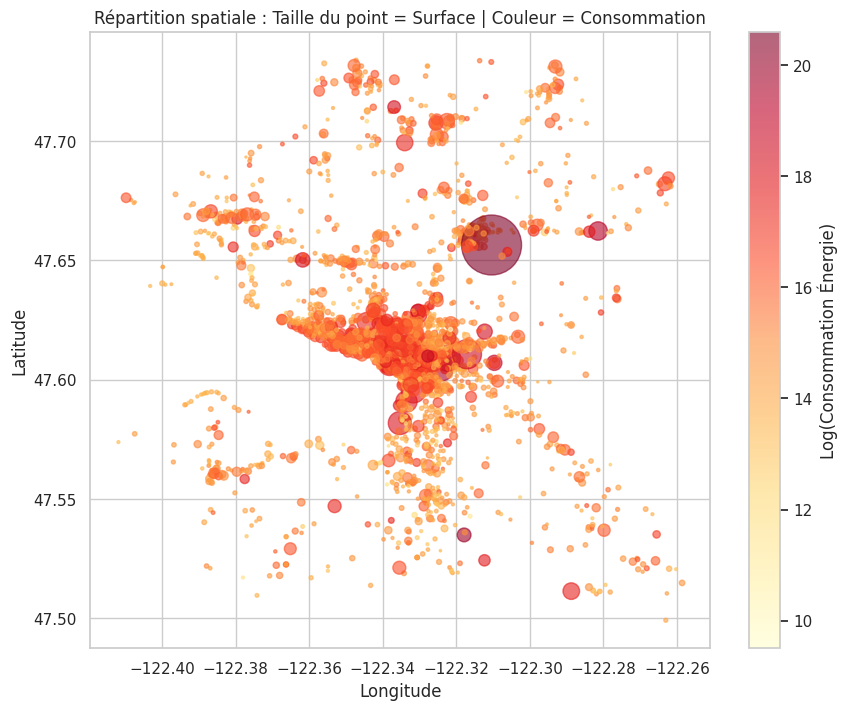

In [ ]:
# RÉFLEXE SENIOR : On vérifie si la localisation géographique influe sur la consommation
print("CARTOGRAPHIE DE L'INTENSITÉ ÉNERGÉTIQUE")

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_clean['longitude'], df_clean['latitude'],
                      c=np.log1p(df_clean['siteenergyusekbtu']),
                      cmap='YlOrRd', alpha=0.6, s=df_clean['propertygfatotal']/5000)

plt.colorbar(scatter, label='Log(Consommation Énergie)')
plt.title("Répartition spatiale : Taille du point = Surface | Couleur = Consommation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
geospatial_analysis(df_clean,value_col='siteenergyusekbtu')

## NALYSE TEMPORELLE - ANNÉE DE CONSTRUCTION

ANALYSE TEMPORELLE - ANNÉE DE CONSTRUCTION


/tmp/ipython-input-3129119.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(century_data, labels=labels, patch_artist=True,


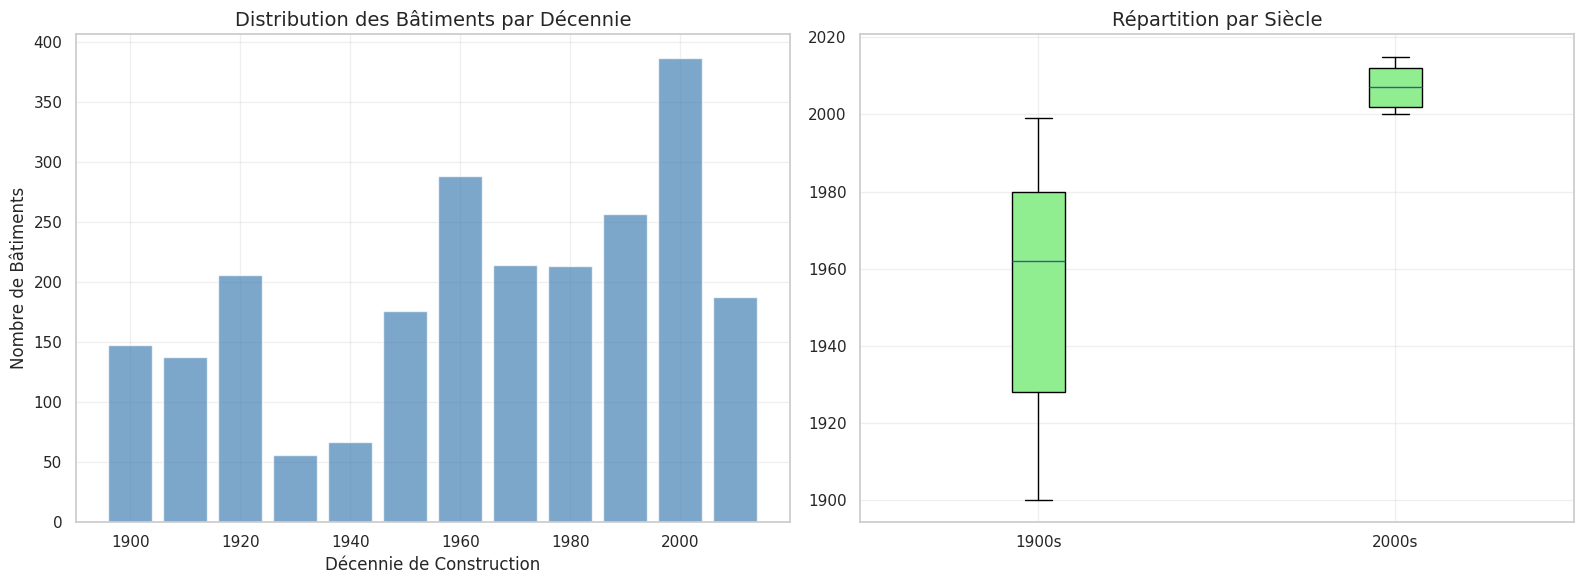


Statistiques temporelles :
   • Bâtiment le plus ancien : 1900
   • Âge médian du parc : 43 ans


In [ ]:
print("ANALYSE TEMPORELLE - ANNÉE DE CONSTRUCTION")
print("=" * 50)

if 'yearbuilt' in df_clean.columns:
    # On filtre les années pour garder le focus sur la période 1900-2016
    valid_years = df_clean['yearbuilt'][(df_clean['yearbuilt'] > 1850) & (df_clean['yearbuilt'] <= 2016)]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Visualisation 1 : Histogramme par Décennie
    decades = (valid_years // 10) * 10
    decade_counts = decades.value_counts().sort_index()

    axes[0].bar(decade_counts.index, decade_counts.values, width=8, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Décennie de Construction')
    axes[0].set_ylabel('Nombre de Bâtiments')
    axes[0].set_title('Distribution des Bâtiments par Décennie', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # Visualisation 2 : Boxplot par Siècle (Structure du parc)
    # Note : Le boxplot montre ici l'étalement des années de construction par bloc de 100 ans
    centuries = (valid_years // 100) * 100
    century_data = [valid_years[centuries == c] for c in sorted(centuries.unique())]
    labels = [f'{int(c)}s' for c in sorted(centuries.unique())]

    axes[1].boxplot(century_data, labels=labels, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen'))
    axes[1].set_title('Répartition par Siècle', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistiques clés
    print(f"\nStatistiques temporelles :")
    print(f"   • Bâtiment le plus ancien : {int(valid_years.min())}")
    print(f"   • Âge médian du parc : {int(2016 - valid_years.median())} ans")

## ÉVOLUTION DE L'INTENSITÉ CARBONE PAR ANNÉE DE CONSTRUCTION

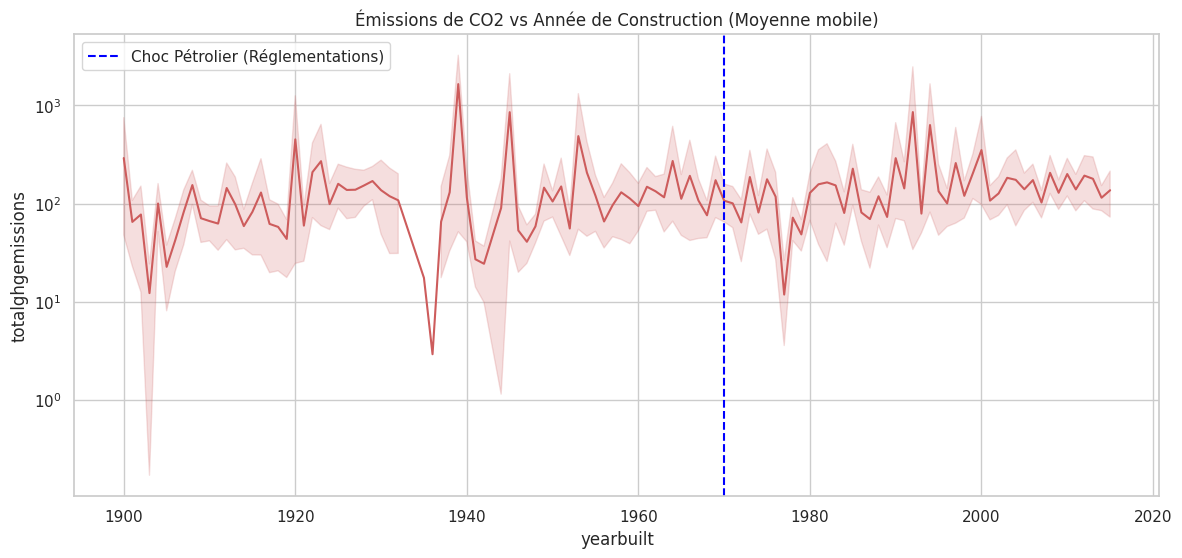

In [ ]:
# RÉFLEXE SENIOR : Est-ce que "vieux" veut dire "sale" ?
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_clean, x='yearbuilt', y='totalghgemissions', color='indianred')
plt.yscale('log')
plt.title("Émissions de CO2 vs Année de Construction (Moyenne mobile)")
plt.axvline(1970, color='blue', linestyle='--', label='Choc Pétrolier (Réglementations)')
plt.legend()
plt.show()

## Corrélations & Interdépendances

/tmp/ipython-input-1313216006.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')


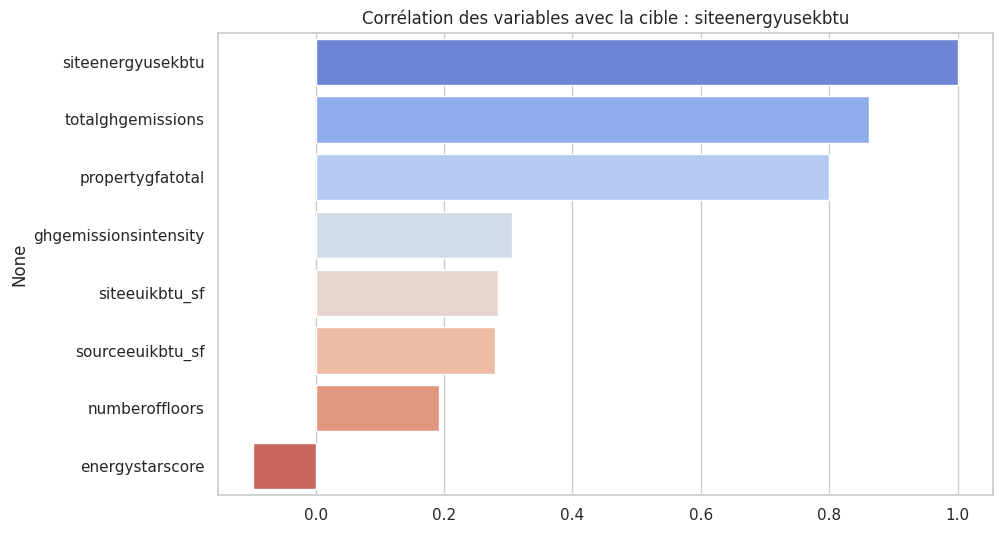


CORRÉLATIONS FORTES DÉTECTÉES (Risque de Multicolinéarité) :


,,0
siteeuikbtu_sf,sourceeuikbtu_sf,0.949
siteenergyusekbtu,totalghgemissions,0.861
propertygfatotal,siteenergyusekbtu,0.800
ghgemissionsintensity,siteeuikbtu_sf,0.724


In [ ]:
# Mise à jour des noms de colonnes (snake_case)
numeric_vars = [
    'siteenergyusekbtu', 'siteeuikbtu_sf', 'sourceeuikbtu_sf',
    'propertygfatotal', 'numberoffloors', 'energystarscore',
    'totalghgemissions', 'ghgemissionsintensity'
]

# Filtrage des colonnes existantes
numeric_vars = [var for var in numeric_vars if var in df_clean.columns]

if len(numeric_vars) >= 3:
    # On utilise ta fonction correlation_analysis
    # Elle compare Pearson (sensible aux outliers) et Spearman (robuste)
    corr_results = correlation_analysis(df_clean[numeric_vars],
                                        target_col='siteenergyusekbtu',
                                        method='both',
                                        threshold=0.7)

    # Affichage des alertes de redondance
    if not corr_results['strong_pearson'].empty:
        print("\nCORRÉLATIONS FORTES DÉTECTÉES (Risque de Multicolinéarité) :")
        display(corr_results['strong_pearson'])

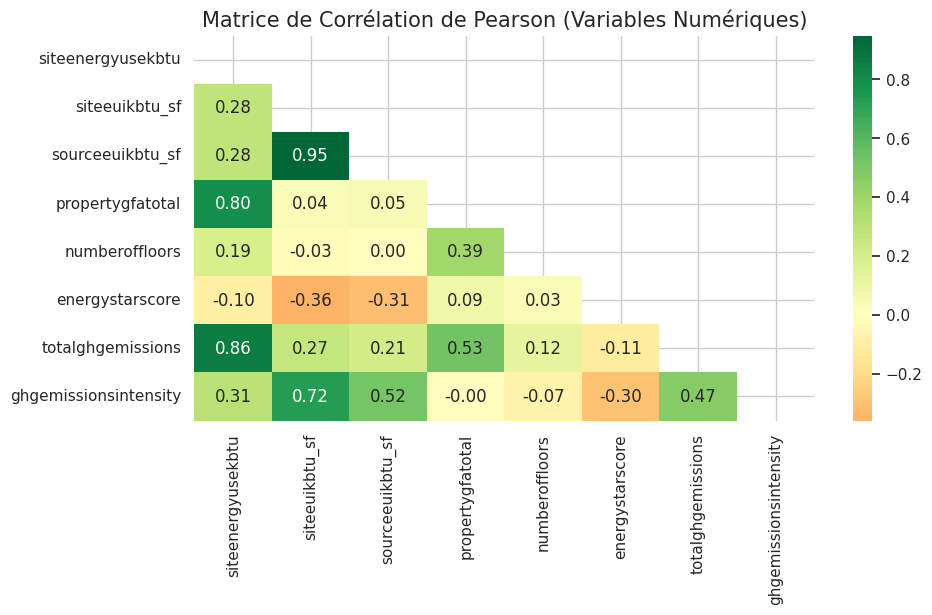

In [ ]:
# Affichage visuel pour le rapport GreenSight
plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(df_clean[numeric_vars].corr(), dtype=bool))

sns.heatmap(df_clean[numeric_vars].corr(),
            mask=mask, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
plt.title("Matrice de Corrélation de Pearson (Variables Numériques)", fontsize=15)
plt.show()

## Diagnostic de l'Efficacité (ENERGY STAR)

/tmp/ipython-input-302955315.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=valid_data, x='score_category', y=site_eui, ax=axes[1], palette='RdYlGn_r')


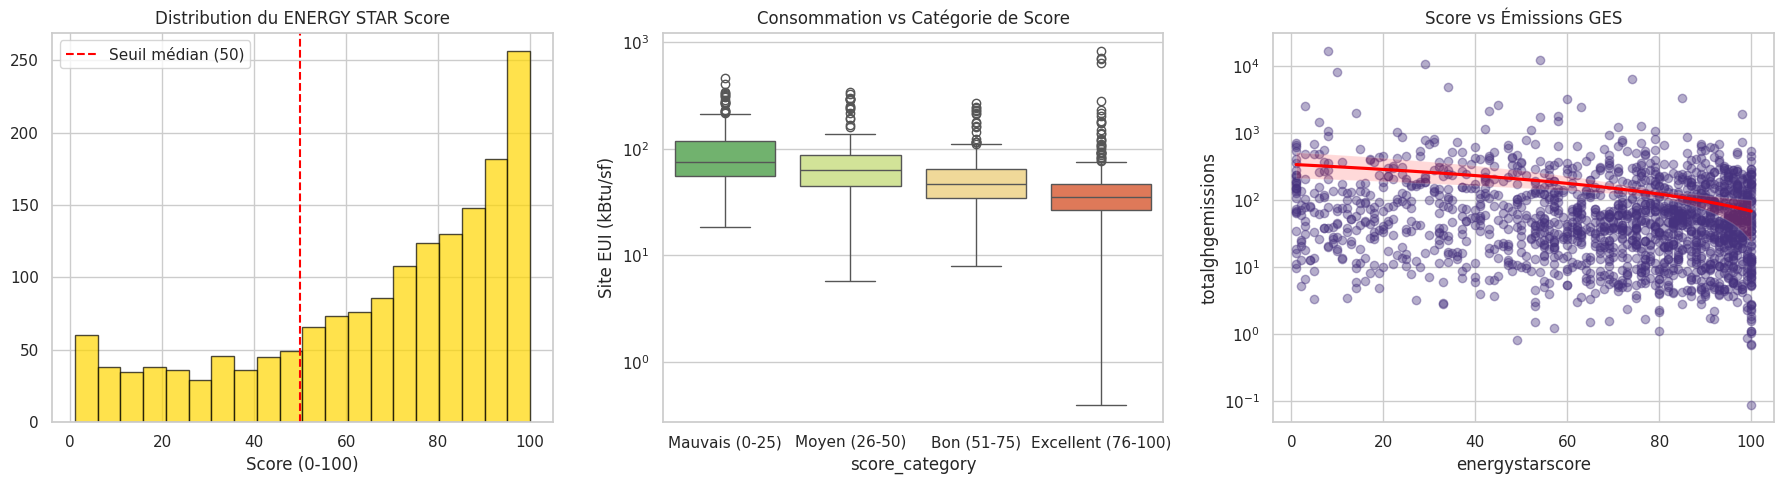

In [ ]:
# On utilise df_clean et les noms normalisés
target_score = 'energystarscore'
site_eui = 'siteeuikbtu_sf'
emissions = 'totalghgemissions'

if target_score in df_clean.columns:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Histogramme : Est-ce que les bâtiments de Seattle sont de "bons élèves" ?
    axes[0].hist(df_clean[target_score].dropna(), bins=20, alpha=0.7, color='gold', edgecolor='black')
    axes[0].axvline(x=50, color='red', linestyle='--', label='Seuil médian (50)')
    axes[0].set_title('Distribution du ENERGY STAR Score')
    axes[0].set_xlabel('Score (0-100)')
    axes[0].legend()

    # 2. Boxplot : Consommation par quartiles de score
    # On crée des catégories pour voir si un haut score réduit réellement la facture
    valid_data = df_clean[[target_score, site_eui]].dropna()
    if not valid_data.empty:
        bins = [0, 25, 50, 75, 100]
        labels = ['Mauvais (0-25)', 'Moyen (26-50)', 'Bon (51-75)', 'Excellent (76-100)']
        valid_data['score_category'] = pd.cut(valid_data[target_score], bins=bins, labels=labels)

        sns.boxplot(data=valid_data, x='score_category', y=site_eui, ax=axes[1], palette='RdYlGn_r')
        axes[1].set_title('Consommation vs Catégorie de Score')
        axes[1].set_ylabel('Site EUI (kBtu/sf)')
        axes[1].set_yscale('log') # Log scale car l'EUI peut varier énormément

    # 3. Scatter plot : Score vs Émissions (La preuve par l'image)
    valid_emissions = df_clean[[target_score, emissions]].dropna()
    if not valid_emissions.empty:
        sns.regplot(data=valid_emissions, x=target_score, y=emissions,
                    ax=axes[2], scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
        axes[2].set_title('Score vs Émissions GES')
        axes[2].set_yscale('log')

    plt.tight_layout()
    plt.show()

In [ ]:
# Analyse mathématique de la force du score comme prédicteur
energy_vars = ['siteeuikbtu_sf', 'totalghgemissions', 'siteenergyusekbtu', 'ghgemissionsintensity']
corr_scores = []

for var in energy_vars:
    if var in df_clean.columns:
        # On calcule Pearson et Spearman
        p_corr = df_clean[[target_score, var]].corr(method='pearson').iloc[0,1]
        s_corr = df_clean[[target_score, var]].corr(method='spearman').iloc[0,1]
        corr_scores.append({'Variable': var, 'Pearson': p_corr, 'Spearman': s_corr})

display(pd.DataFrame(corr_scores).sort_values(by='Spearman'))

,Variable,Pearson,Spearman
0,siteeuikbtu_sf,-0.359,-0.526
3,ghgemissionsintensity,-0.296,-0.298
2,siteenergyusekbtu,-0.097,-0.194
1,totalghgemissions,-0.114,-0.143


## Audit de Multicolinéarité (VIF)

In [ ]:
# Utilisation des noms normalisés (df_clean)
indep_vars = [
    'propertygfatotal', 'propertygfabuildings', 'propertygfaparking',
    'numberoffloors', 'numberofbuildings', 'energystarscore',
    'siteeuikbtu_sf', 'sourceeuikbtu_sf'
]

# Filtrage et nettoyage des NaNs pour le calcul matriciel
vif_input = df_clean[indep_vars].dropna()

if not vif_input.empty:
    vif_results = calculate_vif(vif_input)

    print("\nRÉSULTATS VIF (Indice de redondance) :")
    display(vif_results)

    # Alerte automatique
    problematic = vif_results[vif_results['VIF'] > 10]
    if not problematic.empty:
        print(f"\nALERTE : {len(problematic)} variables sont trop corrélées (VIF > 10)")


RÉSULTATS VIF (Indice de redondance) :


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,propertygfatotal,inf
1,propertygfabuildings,inf
2,propertygfaparking,inf
6,siteeuikbtu_sf,24.419
7,sourceeuikbtu_sf,22.565
4,numberofbuildings,4.966
5,energystarscore,3.724
3,numberoffloors,2.914



ALERTE : 5 variables sont trop corrélées (VIF > 10)


# ENgineering

In [ ]:
def create_features(df):
    """
    Génère des indicateurs métiers pour améliorer la performance prédictive.
    """
    df_new = df.copy()
    descriptions = {}

    # 1. Variables Temporelles
    df_new['building_age'] = 2016 - df_new['yearbuilt']
    descriptions['building_age'] = "Âge du bâtiment au moment de l'étude (2016)"

    # 2. Variables de Densité et Forme
    # On évite la division par zéro avec une petite constante (epsilon)
    df_new['gfa_per_floor'] = df_new['propertygfatotal'] / (df_new['numberoffloors'].replace(0, 1))
    descriptions['gfa_per_floor'] = "Surface moyenne par étage (indique l'étalement)"

    # 3. Part du Parking (Souvent très consommateur en éclairage/ventilation)
    df_new['parking_ratio'] = df_new['propertygfaparking'] / df_new['propertygfatotal']
    descriptions['parking_ratio'] = "Proportion de la surface dédiée au parking"

    # 4. Indicateur de complexité d'usage
    # Si le bâtiment a plusieurs usages, il est souvent plus difficile à optimiser
    df_new['is_multipurpose'] = df_new['listofallpropertyusetypes'].str.count(',').fillna(0) + 1
    descriptions['is_multipurpose'] = "Nombre d'usages différents déclarés"

    return df_new, descriptions

In [ ]:
# On applique la fonction sur le dataset nettoyé
df_enhanced, feature_descriptions = create_features(df_clean)

print(f"{len(feature_descriptions)} nouvelles features créées :")
for feat, desc in feature_descriptions.items():
    print(f"   • {feat} : {desc}")

# Visualisation statistique
print(f"\nANALYSE STATISTIQUE DES NOUVEAUX INDICATEURS :")
new_features = list(feature_descriptions.keys())
display(df_enhanced[new_features].describe().T)

4 nouvelles features créées :
   • building_age : Âge du bâtiment au moment de l'étude (2016)
   • gfa_per_floor : Surface moyenne par étage (indique l'étalement)
   • parking_ratio : Proportion de la surface dédiée au parking
   • is_multipurpose : Nombre d'usages différents déclarés

ANALYSE STATISTIQUE DES NOUVEAUX INDICATEURS :


,count,mean,std,min,25%,50%,75%,max
building_age,2338.000,47.368,33.977,1.000,17.000,43.000,69.000,116.000
gfa_per_floor,2338.000,33813.356,199164.308,221.697,10479.250,18357.750,31930.000,9320156.000
parking_ratio,2338.000,0.054,0.130,0.000,0.000,0.000,0.000,0.895
is_multipurpose,2338.000,1.919,1.189,1.000,1.000,2.000,2.000,13.000


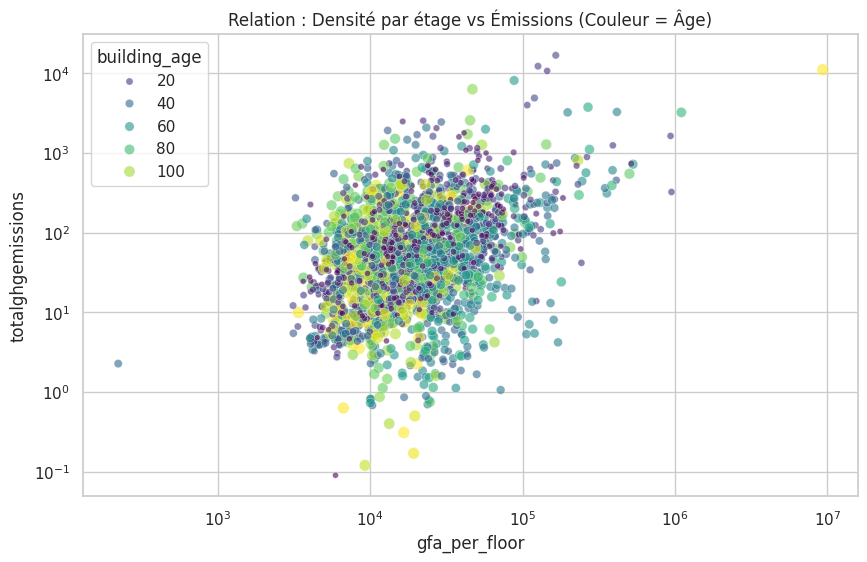

In [ ]:
# On vérifie si notre variable 'gfa_per_floor' est liée au CO2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_enhanced, x='gfa_per_floor', y='totalghgemissions',
                hue='building_age', size='building_age', palette='viridis', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.title("Relation : Densité par étage vs Émissions (Couleur = Âge)")
plt.show()

* Corrélation de Densité : On observe une relation linéaire positive entre la surface par étage (gfa_per_floor) et les émissions. Plus un bâtiment est "épais" ou massif sur un même niveau, plus son inertie thermique et ses besoins en éclairage/ventilation augmentent ses émissions de CO2​.

* L'Effet de l'Âge : La répartition des couleurs montre que les bâtiments plus anciens (jaune/vert, 80-100 ans) ne sont pas systématiquement les plus polluants à surface égale, mais ils présentent une plus grande variabilité. Les bâtiments récents (bleu/violet) semblent mieux regroupés, suggérant des normes de construction plus homogènes.

In [ ]:

def create_lome_context_features(df):
    df_new = df.copy()

    # 1. Ratio de compacité (Surface vs Hauteur)
    # Un bâtiment haut et fin capte plus de soleil sur ses parois qu'un bâtiment compact.
    df_new['compactness_ratio'] = df_new['numberoffloors'] / (np.log1p(df_new['propertygfatotal']))

    # 2. Intensité Électrique (La variable clé à Lomé)
    # On isole la part de l'électricité dans la consommation totale.
    if 'electricitykbtu' in df_new.columns and 'siteenergyusekbtu' in df_new.columns:
        df_new['elec_dependency'] = df_new['electricitykbtu'] / (df_new['siteenergyusekbtu'] + 1)

    # 3. Potentiel Solaire (Proxy)
    # Ratio de la surface au sol (Toiture potentielle) par rapport à la surface totale.
    # Utile pour les stratégies d'autoconsommation à Lomé.
    df_new['solar_potential_ratio'] = df_new['propertygfabuildings'] / (df_new['propertygfatotal'] + 1)

    # 4. Charge d'Occupation Estimée
    # Plus un bâtiment a d'usages différents, plus la gestion de la clim est complexe.
    df_new['usage_complexity'] = df_new['listofallpropertyusetypes'].str.count(',') + 1

    # 5. Ratio "GFA par Bâtiment"
    # Si numberofbuildings > 1, c'est un campus. La déperdition est plus forte.
    df_new['avg_building_size'] = df_new['propertygfabuildings'] / (df_new['numberofbuildings'].replace(0, 1))

    return df_new

df_lome = create_lome_context_features(df_enhanced)
print("5 Nouvelles variables 'Expert' ajoutées au dataset.")

5 Nouvelles variables 'Expert' ajoutées au dataset.


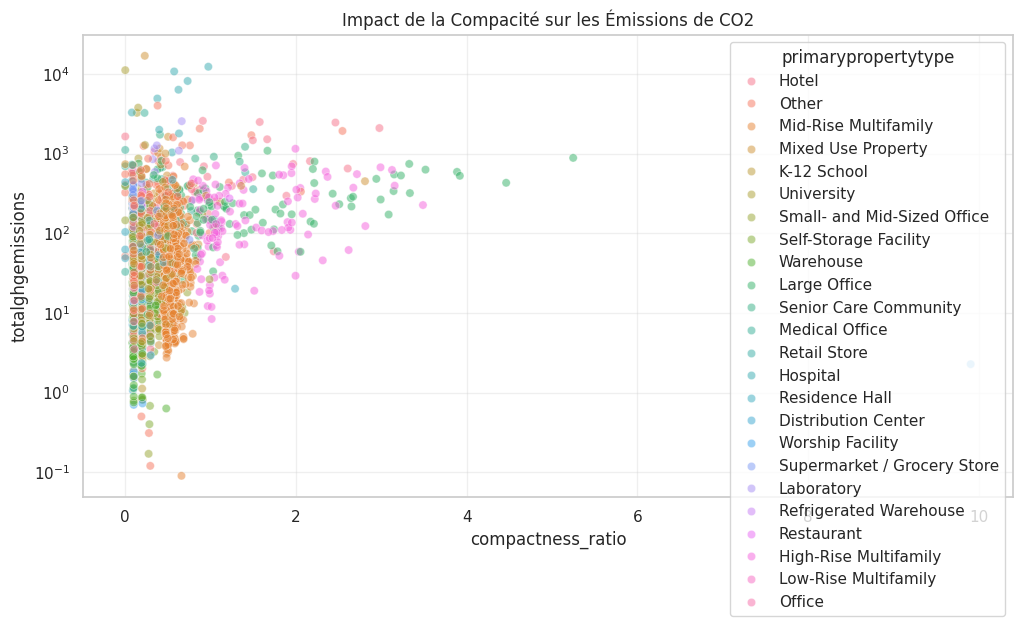

In [ ]:
plt.figure(figsize=(12, 6))
# On regarde si les bâtiments compacts (plus adaptés aux climats chauds) polluent moins
sns.scatterplot(data=df_lome, x='compactness_ratio', y='totalghgemissions',
                hue='primarypropertytype', alpha=0.5)
plt.yscale('log')
plt.title("Impact de la Compacité sur les Émissions de CO2")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def geospatial_analysis(df, lat_col, lon_col, value_col, radius=15):
    """
    Génère une carte de chaleur interactive basée sur la consommation.
    """
    # Nettoyage local des NaNs pour la carte
    data = df[[lat_col, lon_col, value_col]].dropna()

    if data.empty:
        return None

    # Initialisation de la carte centrée sur la moyenne des coordonnées
    m = folium.Map(location=[data[lat_col].mean(), data[lon_col].mean()],
                   zoom_start=12,
                   tiles='cartodbpositron')

    # Préparation des données pour la HeatMap [[lat, lon, weight]]
    heat_data = [[row[lat_col], row[lon_col], row[value_col]] for index, row in data.iterrows()]

    # Ajout de la couche de chaleur
    HeatMap(heat_data, radius=radius, blur=10, max_zoom=1).add_to(m)

    return m

In [ ]:

# Adaptation aux noms snake_case : 'latitude', 'longitude', 'siteenergyusekbtu'
lat, lon, val = 'latitude', 'longitude', 'siteenergyusekbtu'

if all(col in df_enhanced.columns for col in [lat, lon, val]):
    print("Génération de la carte de chaleur...")

    energy_map = geospatial_analysis(df_enhanced, lat, lon, val)

    if energy_map:
        energy_map.save('energy_consumption_heatmap.html')
        print(f"Carte sauvegardée sous : energy_consumption_heatmap.html")

        # --- ANALYSE DES QUARTIERS ---
        print("\n🏆 TOP 5 DES QUARTIERS LES PLUS ÉNERGIVORES :")
        top_neigh = df_enhanced.groupby('neighborhood')[val].sum().nlargest(5)
        for i, (name, total) in enumerate(top_neigh.items(), 1):
            print(f"{i}. {name:20s} : {total:,.0f} kBtu")
    else:
        print("Données insuffisantes pour la carte.")

Génération de la carte de chaleur...
Carte sauvegardée sous : energy_consumption_heatmap.html

🏆 TOP 5 DES QUARTIERS LES PLUS ÉNERGIVORES :
1. DOWNTOWN             : 5,377,988,388 kBtu
2. EAST                 : 2,279,474,860 kBtu
3. NORTHEAST            : 1,981,009,638 kBtu
4. GREATER DUWAMISH     : 1,802,472,868 kBtu
5. LAKE UNION           : 1,643,094,844 kBtu


In [ ]:
df_enhanced.head()

,osebuildingid,datayear,buildingtype,primarypropertytype,propertyname,address,city,state,zipcode,taxparcelidentificationnumber,councildistrictcode,neighborhood,latitude,longitude,yearbuilt,numberofbuildings,numberoffloors,propertygfatotal,propertygfaparking,propertygfabuildings,listofallpropertyusetypes,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyusetypegfa,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,yearsenergystarcertified,energystarscore,siteeuikbtu_sf,siteeuiwnkbtu_sf,sourceeuikbtu_sf,sourceeuiwnkbtu_sf,siteenergyusekbtu,siteenergyusewnkbtu,steamusekbtu,electricitykwh,electricitykbtu,naturalgastherms,naturalgaskbtu,defaultdata,comments,compliancestatus,outlier,totalghgemissions,ghgemissionsintensity,building_age,gfa_per_floor,parking_ratio,is_multipurpose
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.000,0659000030,7,DOWNTOWN,47.612,-122.338,1927,1.000,12,88434,0,88434,Hotel,Hotel,88434.000,NaN,NaN,NaN,NaN,NaN,60.000,81.700,84.300,182.500,189.000,7226362.500,7456910.000,2003882.000,1156514.250,3946027.000,12764.529,1276453.000,False,NaN,Compliant,NaN,249.980,2.830,89,7369.500,0.000,1
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.000,0659000220,7,DOWNTOWN,47.613,-122.334,1996,1.000,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.000,Parking,15064.000,Restaurant,4622.000,NaN,61.000,94.800,97.900,176.100,179.400,8387933.000,8664479.000,0.000,950425.188,3242851.000,51450.816,5145082.000,False,NaN,Compliant,NaN,295.860,2.860,20,9415.091,0.145,3
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.000,0659000475,7,DOWNTOWN,47.614,-122.338,1969,1.000,41,956110,196718,759392,Hotel,Hotel,756493.000,NaN,NaN,NaN,NaN,NaN,43.000,96.000,97.700,241.900,244.100,72587024.000,73937112.000,21566554.000,14515435.000,49526664.000,14938.000,1493800.000,False,NaN,Compliant,NaN,2089.280,2.190,47,23319.756,0.206,1
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.000,0659000640,7,DOWNTOWN,47.614,-122.337,1926,1.000,10,61320,0,61320,Hotel,Hotel,61320.000,NaN,NaN,NaN,NaN,NaN,56.000,110.800,113.300,216.200,224.000,6794584.000,6946800.500,2214446.250,811525.312,2768924.000,18112.131,1811213.000,False,NaN,Compliant,NaN,286.430,4.670,90,6132.000,0.000,1
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.000,0659000970,7,DOWNTOWN,47.614,-122.340,1980,1.000,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.000,Parking,68009.000,Swimming Pool,0.000,NaN,75.000,114.800,118.700,211.400,215.600,14172606.000,14656503.000,0.000,1573448.625,5368607.000,88039.984,8803998.000,False,NaN,Compliant,NaN,505.010,2.880,36,9754.444,0.353,3


In [ ]:
df_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2338 entries, 0 to 3375
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   osebuildingid                    2338 non-null   int64  
 1   datayear                         2338 non-null   int64  
 2   buildingtype                     2338 non-null   object 
 3   primarypropertytype              2338 non-null   object 
 4   propertyname                     2338 non-null   object 
 5   address                          2338 non-null   object 
 6   city                             2338 non-null   object 
 7   state                            2338 non-null   object 
 8   zipcode                          2322 non-null   float64
 9   taxparcelidentificationnumber    2338 non-null   object 
 10  councildistrictcode              2338 non-null   int64  
 11  neighborhood                     2338 non-null   object 
 12  latitude                 

In [ ]:
# --- 1. NETTOYAGE RADICAL (DROPS) ---
# Suppression des colonnes identifiées comme inutiles par l'EDA
cols_to_drop = [
    'comments', 'outlier', 'yearsenergystarcertified',
    'secondlargestpropertyusetype', 'secondlargestpropertyusetypegfa',
    'thirdlargestpropertyusetype', 'thirdlargestpropertyusetypegfa'
]
df_enhanced.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# --- 2. TRAITEMENT DE L'ENERGY STAR SCORE (PIVOT) ---
# Étape A : Créer un flag "Missing" pour que le modèle sache que la donnée a été imputée
# C'est crucial car l'absence de score est souvent corrélée à l'âge du bâtiment
df_enhanced['energystarscore_is_missing'] = df_enhanced['energystarscore'].isna().astype(int)

# Étape B : Imputation par la médiane du type de bâtiment (plus précis que la médiane globale)
df_enhanced['energystarscore'] = df_enhanced.groupby('primarypropertytype')['energystarscore'].transform(
    lambda x: x.fillna(x.median())
)

# Étape C : Sécurité pour les types n'ayant aucun score (si rare)
df_enhanced['energystarscore'] = df_enhanced['energystarscore'].fillna(df_enhanced['energystarscore'].median())

# --- 3. TRAITEMENT DES RÉSIDUS NUMÉRIQUES ET CATÉGORIELS ---
# Imputation des colonnes physiques par le mode ou la médiane
df_enhanced['zipcode'] = df_enhanced['zipcode'].fillna(df_enhanced['zipcode'].mode()[0])
df_enhanced['largestpropertyusetype'] = df_enhanced['largestpropertyusetype'].fillna('Unknown')
df_enhanced['largestpropertyusetypegfa'] = df_enhanced['largestpropertyusetypegfa'].fillna(df_enhanced['propertygfatotal'])

# Imputation des rares lignes manquantes sur l'énergie (WN = Weather Normalized)
# Il ne manque qu'une seule valeur dans ton dataset actuel
df_enhanced['siteeuiwnkbtu_sf'] = df_enhanced['siteeuiwnkbtu_sf'].fillna(df_enhanced['siteeuikbtu_sf'])
df_enhanced['siteenergyusewnkbtu'] = df_enhanced['siteenergyusewnkbtu'].fillna(df_enhanced['siteenergyusekbtu'])

# --- 4. VÉRIFICATION FINALE ---
print(f"Lignes restantes : {df_enhanced.shape[0]}")
print(f"Valeurs manquantes totales : {df_enhanced.isna().sum().sum()}")

Lignes restantes : 2338
Valeurs manquantes totales : 0


In [ ]:
# --- Niveau 1 : Caractéristiques Temporelles et Structurelles ---
df=df_enhanced.copy()
# 1. Âge et sécurité sur les dates
# On s'assure que l'âge ne soit pas négatif (données erronées)
df['building_age'] = (2016 - df['yearbuilt']).apply(lambda x: x if x >= 0 else 0)

# 2. Catégorisation (Utile pour l'analyse et les modèles linéaires)
age_bins = [0, 25, 50, 75, 100, df['building_age'].max() + 1]
age_labels = ['New', 'Modern', 'Mature', 'Old', 'Historic']
df['building_age_category'] = pd.cut(df['building_age'], bins=age_bins, labels=age_labels)

# 3. Ratios de Surface (Optimisation de la mémoire et gestion des divisions)
# On remplace les 0 par la médiane pour éviter les divisions par zéro infinies
total_gfa_safe = df['propertygfatotal'].replace(0, df['propertygfatotal'].median())

# Ratio Parking : Impact fort sur l'intensité énergétique (ventilation/éclairage)
df['parking_ratio'] = df['propertygfaparking'] / total_gfa_safe

# Floor Density (Footprint par étage)
# On utilise propertygfabuildings pour exclure le parking de la densité habitable
floors_safe = df['numberoffloors'].replace(0, 1)
df['floor_density'] = (df['propertygfabuildings'] / floors_safe) / 1000

# NEW: Define primary_usage_dominance
df['primary_usage_dominance'] = df['largestpropertyusetypegfa'] / total_gfa_safe.replace(0, 1)

# 4. Nettoyage des colonnes redondantes (Optionnel mais recommandé)
# Si BuildingToTotalRatio = 1 - ParkingRatio, on ne garde que ParkingRatio.


In [ ]:
# --- Niveau 2 : Caractéristiques d'Usage et de Mixité (Version Corrigée) ---

# 1. On a déjà PrimaryUsageDominance, on va calculer le "Reste"
# Le "Reste" représente la part de tous les usages secondaires et tertiaires
df['remaining_usage_dominance'] = 1 - df['primary_usage_dominance']

# 2. Balance des usages (Version Senior adaptée)
# Au lieu de P² + S² + T³, on utilise un indice de concentration simplifié :
# Si le bâtiment est Mixed Use, on considère que le "reste" est réparti.
# Cela évite d'avoir besoin des colonnes supprimées.
df['usage_balance_index'] = (
    df['primary_usage_dominance']**2 +
    df['remaining_usage_dominance']**2
)

# 3. Raffinement de la complexité
# On s'assure que le ratio de dominance est bien borné (sécurité)
df['primary_usage_dominance'] = df['primary_usage_dominance'].clip(0, 1)
df['remaining_usage_dominance'] = df['remaining_usage_dominance'].clip(0, 1)

print("Niveau 2 restructuré et compatible avec le nettoyage précédent.")

Niveau 2 restructuré et compatible avec le nettoyage précédent.


In [ ]:
# --- Niveau 3 : Performance Énergétique (Version Sécurisée) ---

# 1. EUI Ratio (Efficacité Source vs Site)
# Représente la perte énergétique lors de la génération/transport
df['eui_ratio'] = (df['siteeuikbtu_sf'] / df['sourceeuikbtu_sf'].clip(lower=1)).clip(0, 1)

# 2. Score d'Efficacité Normalisé (Déjà imputé au niveau Senior précédent)
df['energy_efficiency_score'] = df['energystarscore'] / 100

# 3. Remplacement de CertificationIntensity (Binaire)
# Puisqu'on a jeté la colonne trop vide, on crée un flag sur le top performance
df['is_high_performer'] = (df['energystarscore'] >= 80).astype(int)

# 4. Energy Progress Index (Vétusté relative au score)
# On utilise building_age déjà calculé au Niveau 1
# On ajoute +1 à l'âge pour éviter la division par zéro sur les bâtiments neufs
df['energy_vulnerability_index'] = (100 - df['energystarscore']) / (df['building_age'] + 1)

# --- NETTOYAGE DES VARIABLES DE FUITE ---
# On s'assure de ne pas utiliser d'intensités liées au GHG pour le training
cols_to_ignore = ['ghgemissionsintensity', 'siteeuikbtu_sf', 'sourceeuikbtu_sf']
# Note : On garde ces colonnes pour l'instant, mais on ne les passera pas au modèle.


In [ ]:
# --- Niveau 4 : Mix Énergétique (Version Senior) ---

# 1. Sécurisation du dénominateur
total_energy = df['siteenergyusekbtu'].clip(lower=1)

# 2. Calcul des Ratios (L'info la plus importante pour le modèle)
# Ces variables permettent au modèle de comprendre la nature de l'énergie
df['elec_ratio'] = df['electricitykbtu'] / total_energy
df['gas_ratio'] = df['naturalgaskbtu'] / total_energy
df['steam_ratio'] = df['steamusekbtu'] / total_energy

# 3. Intensité Carbone du Mix (Coefficients adaptés à Seattle)
# Gaz : ~0.053 kg CO2/kBtu
# Vapeur : ~0.070 kg CO2/kBtu
# Électricité Seattle : ~0.003 kg CO2/kBtu (très bas !)
df['carbon_intensity_of_mix'] = (
    (df['gas_ratio'] * 0.053) +
    (df['steam_ratio'] * 0.070) +
    (df['elec_ratio'] * 0.003)
)

# 4. Indicateur de dépendance aux énergies fossiles
# Le gaz et la vapeur sont les principaux polluants à Seattle
df['fossil_fuel_dependency'] = df['gas_ratio'] + df['steam_ratio']

print("Niveau 4 terminé : Mix énergétique calibré sur Seattle.")

Niveau 4 terminé : Mix énergétique calibré sur Seattle.


In [ ]:
from sklearn.cluster import KMeans

# --- Niveau 5 : Caractéristiques Spatiales (Version Senior) ---

# 1. Taille moyenne par bâtiment (au lieu de FAR simplifié)
# On évite les divisions par zéro si numberofbuildings est 0
df['avg_building_size'] = (df['propertygfabuildings'] / df['numberofbuildings'].clip(lower=1)) / 1000

# 2. Clustering Géographique
# On crée un "quartier statistique" basé sur la position pure
coords = df[['latitude', 'longitude']]
# 10 clusters est un bon compromis pour Seattle (Nord, Sud, Centre, etc.)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)

# 3. Indicateurs de Centralité
# Le District 7 et le quartier Downtown sont les zones à plus forte densité énergétique
df['is_downtown'] = df['neighborhood'].str.upper().str.contains('DOWNTOWN').astype(int)
df['is_central_district'] = (df['councildistrictcode'] == 7).astype(int)

# 4. Rayon de distance au centre (Optionnel mais puissant)
# Seattle Center (Space Needle) comme point de référence (47.6205, -122.3493)
ref_lat, ref_lon = 47.6205, -122.3493
df['dist_to_center'] = np.sqrt((df['latitude'] - ref_lat)**2 + (df['longitude'] - ref_lon)**2)

print("Niveau 5 terminé : Intelligence spatiale intégrée.")

Niveau 5 terminé : Intelligence spatiale intégrée.


In [ ]:
# --- Niveau 6 : Catégories de Type et Taille (Version Senior) ---

# 1. Mapping Hiérarchique Exhaustif
# On utilise des catégories qui ont des profils de consommation thermique similaires
building_type_mapping = {
    'Hotel': 'Hospitality',
    'Office': 'Commercial', 'Small Office': 'Commercial',
    'K-12 School': 'Education', 'University': 'Education', 'College/University': 'Education',
    'Medical Office': 'Healthcare', 'Hospital': 'Healthcare', 'Senior Care Community': 'Healthcare',
    'Retail Store': 'Commercial', 'Supermarket/Grocery Store': 'Commercial', 'Wholesale Club/Superstore': 'Commercial',
    'Warehouse': 'Storage', 'Distribution Center': 'Storage', 'Self-Storage Facility': 'Storage',
    'Multifamily Housing': 'Residential', 'Low-Rise Multifamily': 'Residential', 'Mid-Rise Multifamily': 'Residential', 'High-Rise Multifamily': 'Residential',
    'Worship Facility': 'Public_Assembly', 'Entertainment/Public Assembly': 'Public_Assembly',
    'Other': 'Other', 'Mixed Use Property': 'Other'
}

# Application du mapping (on passe en majuscules pour éviter les fautes de frappe)
df['building_macro_category'] = df['primarypropertytype'].map(building_type_mapping).fillna('Other')

# 2. Catégorisation de la Taille (Scale Feature)
# On utilise tes seuils mais on s'assure qu'ils sont adaptés à la distribution observée
size_bins = [0, 20000, 50000, 150000, 500000, np.inf]
size_labels = ['Micro', 'Small', 'Medium', 'Large', 'Mega']
df['size_category'] = pd.cut(df['propertygfatotal'], bins=size_bins, labels=size_labels)

# 3. Ratio de spécialisation
# Est-ce que le bâtiment est dédié à un seul usage ou très fragmenté ?
# (Réutilise une logique du niveau 2 avec les colonnes restantes)
df['is_specialized'] = (df['primary_usage_dominance'] > 0.9).astype(int)

print("Niveau 6 terminé : Taxonomie simplifiée et robuste.")

Niveau 6 terminé : Taxonomie simplifiée et robuste.


In [ ]:
# --- Niveau 7 : Interactions et Non-linéarité (Version Senior) ---

# 1. Interactions de Structure (Normalisées)
# L'effet combiné de la vétusté et de la masse thermique (surface)
df['age_size_interaction'] = (df['building_age'] * df['propertygfatotal']) / 1e6

# L'effet de la complexité sur la gestion de la surface
df['usage_size_interaction'] = (df['is_multipurpose'] * df['propertygfatotal']) / 1e5

# 2. Interaction de Performance (Remplacement de la colonne supprimée)
# On regarde si être un "bon élève" (High Performer) a plus d'impact sur les vieux bâtiments
df['perf_age_interaction'] = df['is_high_performer'] * df['building_age']

# 3. Transformations Non-linéaires (Piliers du modèle)
# Log pour réduire l'asymétrie (Skewness) des surfaces
df['log_gfa_total'] = np.log1p(df['propertygfatotal'])
df['log_gfa_building'] = np.log1p(df['propertygfabuildings'])

# Carrés pour capturer les accélérations de tendance
df['age_squared'] = (df['building_age'] / 100) ** 2  # Divisé par 100 pour garder une échelle gérable
df['energy_score_squared'] = (df['energystarscore'] / 100) ** 2

# 4. Interaction Énergie x Type
# Un score de 80 pour un hôpital n'a pas la même valeur qu'un 80 pour un entrepôt
# On crée un indicateur "Score par rapport à la taille"
df['score_per_sqft'] = df['energystarscore'] / df['log_gfa_total']

print("Niveau 7 terminé : Interactions et transformations non-linéaires prêtes.")

Niveau 7 terminé : Interactions et transformations non-linéaires prêtes.


In [ ]:
# --- Niveau 8 : Temporalité et Codes Énergétiques (Version Senior) ---

# 1. Ères de Construction (Ajustées sur les cycles réglementaires de Seattle)
# Pre-1980 : Avant les codes énergétiques modernes (souvent simple vitrage, pas d'isolation)
# 1980-2000 : Premiers codes, isolation standard
# Post-2000 : Codes stricts, LEED, vitrage performant
era_bins = [-np.inf, 1950, 1980, 2000, 2010, np.inf]
era_labels = ['Historic', 'Mid_Century', 'Early_Code', 'Modern', 'High_Performance']

df['construction_era'] = pd.cut(
    df['yearbuilt'],
    bins=era_bins,
    labels=era_labels,
    right=False
)

# 2. Indicateur critique : Avant/Après Code Énergétique
# C'est souvent plus prédictif que l'âge exact
df['is_pre_1980'] = (df['yearbuilt'] < 1980).astype(int)

# 3. Vétusté relative au Code 2016
# Au lieu d'inventer une rénovation, on mesure l'écart technologique réel
# Un bâtiment de 1990 a 26 ans de retard sur les normes 2016
df['regulatory_gap'] = 2016 - df['yearbuilt']

# 4. Décennie (Pour capturer des tendances macro sans trop de granularité)
df['decade_built'] = (df['yearbuilt'] // 10) * 10

print("Niveau 8 terminé : Alignement sur l'historique réglementaire de Seattle.")

Niveau 8 terminé : Alignement sur l'historique réglementaire de Seattle.


In [ ]:
# --- Niveau 9 : Contextualisation Locale (Version Anti-Leakage) ---

# 1. Définition du contexte du quartier (Physique uniquement)
# On utilise 'transform' pour garder la dimension du dataframe sans faire de merge lourd
# Question : Ce bâtiment est-il un géant entouré de nains ?
neighborhood_median_size = df.groupby('neighborhood')['propertygfatotal'].transform('median')
df['size_vs_neighborhood'] = df['propertygfatotal'] / neighborhood_median_size.replace(0, 1)

# Question : Ce bâtiment est-il une vieille ruine dans un quartier neuf ?
neighborhood_median_age = df.groupby('neighborhood')['building_age'].transform('median')
df['age_vs_neighborhood'] = df['building_age'] - neighborhood_median_age

# 2. Contextualisation par Type (Benchmark Interne)
# C'est BEAUCOUP plus puissant : on compare un bureau aux autres bureaux, pas à ses voisins
# Question : Ce bâtiment est-il dense pour son type d'usage ?
type_median_density = df.groupby('primarypropertytype')['floor_density'].transform('median')
df['density_vs_type'] = df['floor_density'] / type_median_density.replace(0, 1)

# 3. Score Energy Star du Quartier (Autorisé avec prudence)
# Cela capture si le quartier est "Green" ou "Vétuste" globalement, sans toucher aux consommations directes
# On utilise transform pour mapper directement la moyenne sur chaque ligne
df['neighborhood_avg_score'] = df.groupby('neighborhood')['energystarscore'].transform('mean')
df['score_vs_neighborhood'] = df['energystarscore'] / df['neighborhood_avg_score'].replace(0, 1)

# --- NETTOYAGE CRITIQUE ---
# On supprime toute référence à EUI ou Emissions dans les features créées
# Si 'SiteEUI(kBtu/sf)' est dans tes colonnes, assure-toi de ne PAS l'utiliser ici.

print("Niveau 9 terminé : Features contextuelles créées sans fuite de données.")

Niveau 9 terminé : Features contextuelles créées sans fuite de données.


In [ ]:
# --- Niveau 10 : Qualité des Données et Conformité (Version Senior) ---

# 1. Score de Confiance dans la Donnée (Data Confidence Score)
# On inverse la logique : 1 = Haute confiance, 0 = Basse confiance
# - Si DefaultData est True, c'est une estimation, donc confiance basse.
# - Si le Score Energy Star manque, on a moins de visibilité.
df['data_confidence_index'] = 1.0

# Pénalité pour les données par défaut (gros impact car c'est une estimation)
if 'defaultdata' in df.columns:
    df.loc[df['defaultdata'] == True, 'data_confidence_index'] -= 0.5

# Pénalité pour le score manquant (impact moyen)
# On utilise la colonne créée lors de l'imputation
if 'energystarscore_is_missing' in df.columns:
    df.loc[df['energystarscore_is_missing'] == 1, 'data_confidence_index'] -= 0.3

# On s'assure que le score reste entre 0 et 1
df['data_confidence_index'] = df['data_confidence_index'].clip(0, 1)


# 2. Encodage du Statut de Conformité (Compliance Status)
# C'est une métadonnée administrative : est-ce que le propriéraire a rendu son dossier à l'heure ?
# Cela reflète la qualité de la gestion du bâtiment (Facility Management).
# "Compliant" = Bon gestionnaire -> potentiellement meilleure maintenance -> moins de fuites.

# On crée un flag binaire simple
df['is_compliant'] = (df['compliancestatus'] == 'Compliant').astype(int)


# 3. Risque Administratif (Sans triche)
# Au lieu de regarder la consommation (triche), on regarde si le bâtiment est "à risque"
# d'être mal noté à cause de son âge ou de son manque de données.
df['admin_risk_flag'] = (
    (df['data_confidence_index'] < 0.5).astype(int) +
    (1 - df['is_compliant'])
)

print("Niveau 10 terminé : Indicateurs de fiabilité des données créés (sans Data Leakage).")

Niveau 10 terminé : Indicateurs de fiabilité des données créés (sans Data Leakage).


In [ ]:
# --- Niveau 11 : Encodage et Secteurs (Version Senior) ---

# 1. Encodage des Districts (Spatiale)
# On transforme les IDs de district en variables binaires
district_cols = pd.get_dummies(df['councildistrictcode'], prefix='dist', drop_first=True)
df = pd.concat([df, district_cols], axis=1)

# 2. Encodage des Macro-Catégories (Plutôt que les types bruts)
# Cela réduit le nombre de colonnes et augmente la densité statistique de chaque feature
macro_type_cols = pd.get_dummies(df['building_macro_category'], prefix='cat', drop_first=True)
df = pd.concat([df, macro_type_cols], axis=1)

# 3. Indicateur de Secteur Public (Affinement)
# On s'assure que la liste correspond bien aux noms exacts dans ton dataset
public_keywords = ['school', 'university', 'college', 'police', 'fire', 'library', 'courthouse', 'museum']
df['is_public_building'] = df['primarypropertytype'].str.lower().apply(
    lambda x: 1 if any(kw in x for kw in public_keywords) else 0
)

# 4. Nettoyage des colonnes sources
# On ne supprime pas encore 'primarypropertytype' car on en aura besoin pour le Niveau 12 (Target Encoding)

In [ ]:
# --- Niveau 12 : Benchmarking et Synthèse (Version Senior / Anti-Leakage) ---

# 1. Benchmarking de Performance Théorique (Basé sur Energy Star)
# On compare le bâtiment à la "norme" sans utiliser sa consommation réelle
df['star_score_percentile'] = df['energystarscore'].rank(pct=True)

# 2. Indicateur de Potentiel de Rénovation (Théorique)
# Un vieux bâtiment avec un mauvais score a un fort potentiel d'amélioration
df['renovation_potential_index'] = (
    (100 - df['energystarscore']) * (df['building_age'] / 100)
)

# 3. Intensité d'Usage de la Surface (Surface vs Étages)
# Un bâtiment qui a beaucoup de surface mais peu d'étages est potentiellement moins efficace
# à cause de la perte thermique par le toit.
df['surface_exposure_index'] = df['propertygfatotal'] / (df['numberoffloors'].clip(lower=1) + 1)

# 4. Score de Complexité Structurelle
# Plus un bâtiment est grand, vieux et multi-usage, plus il est "complexe" à gérer
df['structural_complexity_score'] = (
    df['log_gfa_total'] * (df['building_age'] / 100) * df['is_multipurpose']
)

# 5. NETTOYAGE FINAL AVANT MODÉLISATION
# On supprime toutes les colonnes "Fuite" que tu avais créées si elles existent encore
cols_to_remove = [
    'EUI_Percentile', 'GHG_Percentile', 'ImprovementPotential',
    'CompositeEfficiencyScore', 'GHGEmissionsIntensity', 'siteeuikbtu_sf'
]
df = df.drop(columns=[c for c in cols_to_remove if c in df.columns])

print("Niveau 12 terminé : Variables de synthèse prêtes pour le modèle.")

Niveau 12 terminé : Variables de synthèse prêtes pour le modèle.


In [ ]:
# --- ÉTAPE FINALE : PRÉPARATION DU SET D'ENTRAÎNEMENT ---

# 1. Définition des cibles
target_emissions = 'totalghgemissions'
target_energy = 'siteenergyusekbtu'

# 2. Liste noire des variables à exclure (Fuites + Identifiants + Texte)
drop_cols = [
    # Cibles et dérivés
    'totalghgemissions', 'siteenergyusekbtu', 'siteenergyusewnkbtu',
    'siteeuiwnkbtu_sf', 'sourceeuikbtu_sf', 'sourceeuiwnkbtu_sf',
    'ghgemissionsintensity', 'electricitykwh', 'electricitykbtu',
    'naturalgaskbtu', 'naturalgastherms', 'steamusekbtu',

    # Identifiants et Metadata
    'osebuildingid', 'propertyname', 'address', 'city', 'state', 'zipcode',
    'taxparcelidentificationnumber', 'listofallpropertyusetypes',
    'primarypropertytype', 'neighborhood', 'compliancestatus',
    'building_age_category', 'construction_era', 'size_category',
    'building_macro_category', 'defaultdata'
]

# 3. Création du set de features X
X = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 4. Vérification des types
# On s'assure qu'il ne reste que du numérique (int, float, bool)
non_numeric = X.select_dtypes(exclude=[np.number, bool]).columns
if len(non_numeric) > 0:
    print(f" Attention, colonnes non-numériques restantes : {list(non_numeric)}")
else:
    print(f"Features prêtes : {X.shape[1]} variables conservées.")

 Attention, colonnes non-numériques restantes : ['buildingtype', 'largestpropertyusetype']


In [ ]:
df.to_csv('df_processed_final.csv', index=False)
print("Le dataset final 'df_processed_final.csv' a été sauvegardé.")

Le dataset final 'df_processed_final.csv' a été sauvegardé.
